# Фермер

## Описание проекта

**Цели:**

Отобрать коров для фермера по двум критериям:
- средний удой за год не меньше 6000 кг;
- молоко должно быть вкусным.

**Задачи:**
1) Исследовать данные и обнаружить есть ли проблемы с ними;
2) Определить какие есть взаимосвязи между признаками в данных;
3) Построить несколько моделей и решить какая лучше предсказывает удой и вкус молока.

**План работы:**
1) Загрузка и изучение данных;
2) Предобработка данных;
3) Исследовательский анализ;
4) Проведем корреляционный анализ признаков в датасете `ferma_main.csv`;
5) Посторим модели линейной регрессии;
6) Посторим модели логистической регрессии;
7) Подведём итоги.

Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент.

Признаки в датасете `ferma_main.csv` можно разделить на группы:
- Характеристики коровы: `id`, `Порода`, `порода папы_быка`, `Возраст`.
- Характеристика корма: `ЭКЕ (Энергитическая кормовая единица`), `Сырой протеин, г`, `СПО(Сахаро-протеиновое соотношение)`.
- Характеристика пастбища: `Тип пастбища`.
- Характеристика молока: `Удой, кг`, `Жирность, %`, `Белок, %`, `Вкус молока`.

Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера.
- `id`
- `Имя папы`

Файл `cow_buy.csv` содержит данные о коровах "ЭкоФермы" которых хочет изучить перед покупкой фермер.
- `Порода`
- `Тип пастбища`
- `порода папы_быка`
- `Имя_папы`
- `Текущая_жирность,%`
- `Текущий_уровень_белок,%`
- `Возраст`

У датасета `cow_buy.csv` есть несколько особенностей:
- Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
- Параметры корма `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г` и `СПО (Сахаро-протеиновое соотношение)` отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
- Кроме того, отсутствуют признаки `Удой, кг` и `Вкус молока`. Это целевые признаки, именно их предстоит предсказать.

## Обзор данных

### Загрузка данных

In [2]:
#Подключаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
import phik 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn. metrics import precision_recall_curve
import random
import math

In [3]:
#Считаем CSV файлы и сохраним их в переменные
#Функции `sep` уберем разделение ';' в талицах
#Функцией `decimal` задаим разделение вещественных чисел точкой вместо запятой.
try:
    ferma_main = pd.read_csv('ferma_main.csv', sep = ';', decimal = ',')
    ferma_dad = pd.read_csv('ferma_dad.csv', sep = ';', decimal = ',')
    cow_buy = pd.read_csv('cow_buy.csv', sep = ';', decimal = ',')
except:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep = ';', decimal = ',')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ';', decimal = ',')
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ';', decimal = ',')

### Изучение данных

Изучим данные. Определим, соответствуют ли они описанию задачи и стандартам оформления данных. При необходимости переименуем столбцы.

In [4]:
#Наглядно оценим данные с помощью head()
display(ferma_main.head())
display(ferma_dad.head())
display(cow_buy.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [5]:
#Изучим данные методом info()
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [6]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [7]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Первое, что бросается в глаза не подходящие навзвания столбцов. 

Так как в основном все названия на русском(кроме 'id'), оставим как есть. 

Уберем в названии столбцов различные единицы измерения и рассшифровку слов, это только мешает и усложняет, изначальный формат можно будет посмотерть выше в главе 'Описание проекта'.

Между словами добавим змеиный регистр и сделаем все название прописными буквами.

In [8]:
#Приведем название столбцов к нижнему регистру методами columns, str, lower()
ferma_main.columns = ferma_main.columns.str.lower()
ferma_dad.columns = ferma_dad.columns.str.lower()
cow_buy.columns = cow_buy.columns.str.lower()

In [9]:
#Проверим регистр столбцов
display(ferma_main.head())
display(ferma_dad.head())
display(cow_buy.head())

,id,"удой, кг",эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


,id,имя папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [10]:
#Изменим название столбцов функций rename()
ferma_main.rename(columns={'удой, кг': 'удой', 
                           'эке (энергетическая кормовая единица)': 'эке',
                           'сырой протеин, г': 'сырой_протеин',
                           'спо (сахаро-протеиновое соотношение)': 'спо',
                           'тип пастбища': 'тип_пастбища',
                           'порода папы_быка': 'порода_папы_быка',
                           'жирность,%': 'жирность',
                           'белок,%': 'белок',
                           'вкус молока':'вкус_молока'
                          }, inplace=True)


In [11]:
ferma_main.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [12]:
ferma_dad.rename(columns={'имя папы': 'имя_папы'}, inplace=True)

In [13]:
ferma_dad.head()

,id,имя_папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [14]:
cow_buy.rename(columns={
                            'тип пастбища': 'тип_пастбища',
                            'порода папы_быка': 'порода_папы_быка',
                            'текущая_жирность,%': 'жирность',
                            'текущий_уровень_белок,%': 'белок'
                          }, inplace=True)

In [15]:
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Выводы:
- Изменили название столбцов;
- Изменили разделение вещественных чисел на `.`
- Тип данных в порядке.

## Предобработка данных

Проверим данные на наличие пропусков и дубликатов. Узнаем, корректны ли типы данных у каждого признака. При необходимости устраним все проблемы с данными.

### Поиск пропусков

In [16]:
#Проверим кол-во пропусков методами isna() и sum()
ferma_main.isna().sum()

id                  0
удой                0
эке                 0
сырой_протеин       0
спо                 0
порода              0
тип_пастбища        0
порода_папы_быка    0
жирность            0
белок               0
вкус_молока         0
возраст             0
dtype: int64

In [17]:
ferma_dad.isna().sum()

id          0
имя_папы    0
dtype: int64

In [18]:
cow_buy.isna().sum()


порода              0
тип_пастбища        0
порода_папы_быка    0
имя_папы            0
жирность            0
белок               0
возраст             0
dtype: int64

Во всех датасетах пропусков не обнаружено.

Проверим наличие дубликатов.

### Поиск дубкликатов

In [19]:
ferma_main.duplicated().sum()

5

In [20]:
ferma_dad.duplicated().sum()

0

In [21]:
cow_buy.duplicated().sum()

4

In [22]:
#Наглядно оценим дубликаты 
ferma_main.loc[ferma_main.duplicated() == True]

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


У этих коров одинаковй id, именно по этому это дубликаты. Удалим повторящие строки, их не так много.

In [23]:
#Методом drop_duplicates() удалим дубликаты
ferma_main = ferma_main.drop_duplicates()

In [24]:
#Проверим наличие дубликатов
ferma_main.duplicated().sum()

0

In [25]:
cow_buy.loc[cow_buy.duplicated() == True]

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Здесь не совсем понятно, являются ли данные дубликатами.

Порода, порода папы и имя папы явно может повторяться, когда у коров общий отец. 

Тип пастбища также может быть одинаковое. 

На жирность и белок может влиять много факторов, будем считать, что возможно одинковые характеристики молока.

Данных не так много, при удалении дубликатов потеряем 20% данных, оставим как есть.

Проверим неявные дубликаты. 

In [26]:
#Проверим дубликаты при сочетании нескольких столбцов методомами duplicated().sum()
ferma_main[['удой', 'эке', 'сырой_протеин', 'спо', 'жирность', 'белок']].duplicated().sum()

0

У каждой коровы разные характеристики корма и молока, поэтому дубликтов не должно быть.

In [27]:
#Проверим неявные дубликаты методом unique() у `ferma_main`
for a in ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']:
    print(ferma_main[a].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']


Повторяется название породы папы быка 'Айдиал' и 'Айдиалл'. Заменим 'Айдиалл' на 'Айдиал'.

Тип пастбищ 'Равнинные' заменим на 'равнинное'.

В столбце 'тип_пастбищ' данные прописаны с заглавной буквы. Изменим на строчные для дальнейшего удобства.

In [28]:
#Приведем данные столбца 'тип пастбища' к нижнему регистру методами str, lower() 
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].str.lower()

In [29]:
ferma_main['порода_папы_быка'] = ferma_main['порода_папы_быка'].replace('Айдиалл', 'Айдиал')

In [30]:
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].replace('равнинные', 'равнинное')

In [31]:
#Проверим неявные дубликаты после изменения у датафрейма `ferma_main`
for a in ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'возраст']:
    print(ferma_main[a].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['равнинное' 'холмистое']
['Айдиал' 'Соверин']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']


In [32]:
#Проверим неявные дубликаты методом unique() у `cow_buy`
for a in ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']:
    print(cow_buy[a].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['холмистое' 'равнинное']
['Айдиал' 'Соверин']
['более_2_лет' 'менее_2_лет']


Не явные дубликаты не обнаружены.

Также в данных разные единицы измерения, приведем все данные к международной системе единиц.

Проценты в доли.

Граммы в килограммы.

### Перевод данных к международной системе единиц

In [33]:
#Данные столбца 'сырой_протеин' переведем из г в кг.
#Данные столбцов 'жирность', 'белок' переведем из % в доли ед.
ferma_main['сырой_протеин'] = ferma_main['сырой_протеин'] / 1000
ferma_main['жирность'] = ferma_main['жирность'] / 100
ferma_main['белок'] = ferma_main['белок'] / 100


In [34]:
cow_buy['жирность'] = cow_buy['жирность'] / 100
cow_buy['белок'] = cow_buy['белок'] / 100

In [35]:
ferma_main.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1.743,0.890,Вис Бик Айдиал,равнинное,Айдиал,0.0358,0.03076,вкусно,более_2_лет
1,2,5529,12.8,2.138,0.890,Вис Бик Айдиал,равнинное,Соверин,0.0354,0.03079,вкусно,менее_2_лет
2,3,5810,14.0,1.854,0.885,РефлешнСоверинг,холмистое,Соверин,0.0359,0.03074,не вкусно,более_2_лет
3,4,5895,12.4,2.012,0.885,РефлешнСоверинг,холмистое,Айдиал,0.0340,0.03075,не вкусно,более_2_лет
4,5,5302,12.8,1.675,0.885,Вис Бик Айдиал,равнинное,Соверин,0.0373,0.03073,вкусно,менее_2_лет


In [36]:
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0354,0.03081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,0.0359,0.03074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,0.0340,0.03061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,0.0364,0.03074,более_2_лет


Общий вывод:
- Пропусков не обнаружено
- Данные столбца `тип_пастбища` сделали прописными буквами
- Обработали дубликаты: удалили 5 явных дубликтов и 2 неявных в `ferma_main`
- Изменили единицы измерения: граммы в кг., процента в доли ед.
- Типы данных в порядке

## Исследовательский анализ

1) Проведем статистический анализ всех признаков.
2) Построим графики для каждого признака.
3) Сделаем выводы о данных:
- есть ли вы выбросы, необычное распределение количественных признаков или другие особенности;
- объясним как можно улучшить данные.

In [37]:
#Создам функцию для построения гистораммы и диаграммы размаха
try:
    def build_histogram_boxplot(data_set, name_hist, name_boxplt, name_x, bins):

        print(data_set.describe())
        
        fig, axes = plt.subplots(nrows = 1, ncols = 2 )
        plt.subplots_adjust(wspace=0.5, hspace=0.5, right = 2)
        
        axes[0].set_title(name_hist)
        axes[0].set_ylabel('кол-во повторений')
        axes[0].set_xlabel(name_x)

        axes[1].set_title(name_boxplt)
        axes[1].set_xlabel(name_x)
            
        axes[0].hist(data_set, bins = bins)
        axes[1].boxplot(data_set, vert = False)
        plt.show()
except:
    print('Что то пошло не так(')

In [38]:
#Создадим функцию для построения столбчатой диагрммы 
try:
    def build_pie_chart(data_set, name_bar):
        data_set.value_counts().sort_values(ascending = False).plot(kind = 'pie', autopct='%1.1f%%')
        plt.title(name_bar)
        plt.ylabel('')
        plt.show()
except:
    print('Что то пошло не так(')

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: удой, dtype: float64


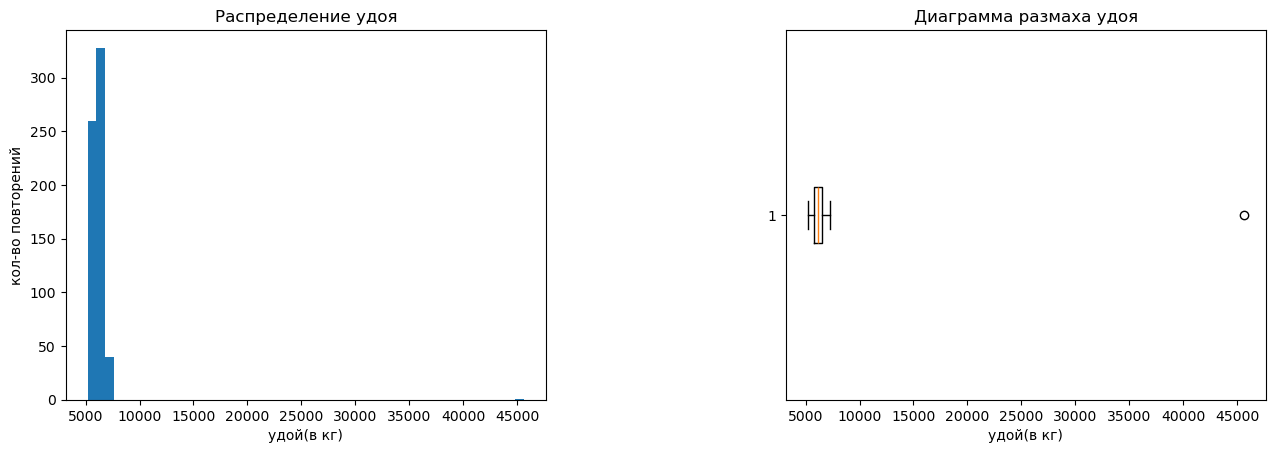

In [39]:
#Вызовем функции для построения графиков всех признаков для всех датафреймов
build_histogram_boxplot(ferma_main['удой'], 'Распределение удоя', 'Диаграмма размаха удоя', 'удой(в кг)', 50)


Значения удоя лежат в примерно в пределах от 5200 - 7600 кг.

Сразу же видно выброс. Удой 45616 кг. явно такого не может быть. Возможно имелось ввиду 4561.6 кг.. Попадается один выброс, но он может значильно повлиять на дальнейшие исследование. Удалим данный выброс.

In [40]:
#Удалим значение удоя 45616 кг. из датасета
ferma_main = ferma_main.query('удой != 45616')

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: удой, dtype: float64


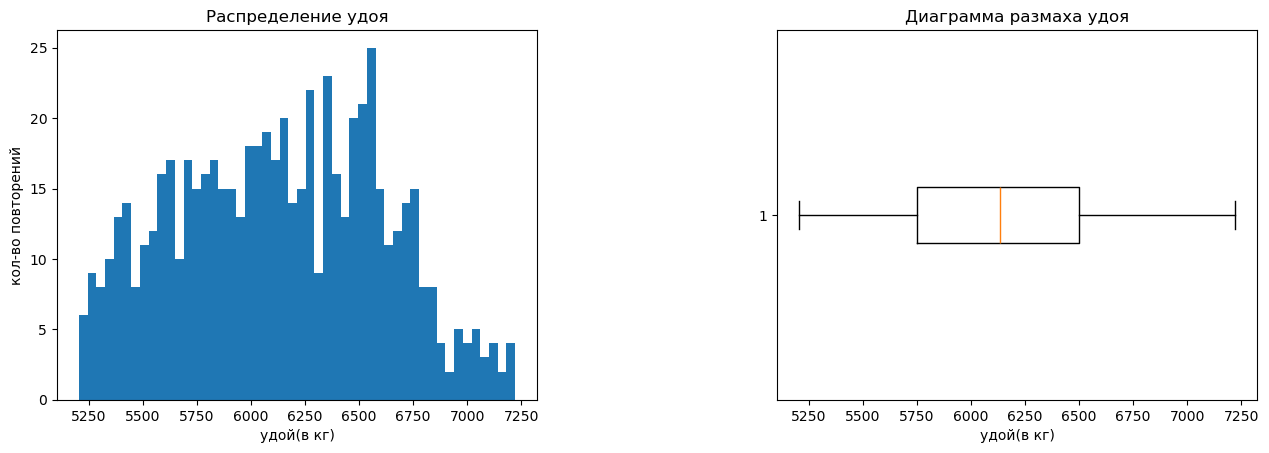

In [41]:
#Проверим данные без выброса
build_histogram_boxplot(ferma_main['удой'], 'Распределение удоя', 'Диаграмма размаха удоя', 'удой(в кг)', 50)

В основном удой получается не больше 6501 кг ..

Остальная часть приходистя на диапазон 6501 - 7222 кг..

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64


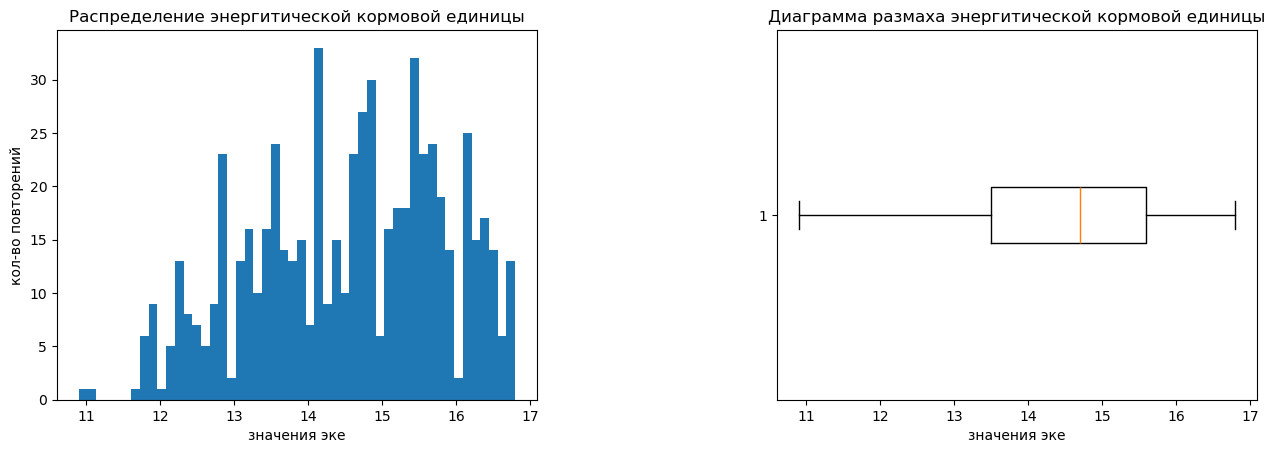

In [42]:
build_histogram_boxplot(ferma_main['эке'], 'Распределение энергитической кормовой единицы', 
                        'Диаграмма размаха энергитической кормовой единицы', 
                        'значения эке', 50)

Показатель питальности корма коровы в основном лежит в диапазоне 10.9 - 15.6.

Аномальных значений и выбросов  не обнаружено.

count    628.000000
mean       1.923760
std        0.182833
min        1.660000
25%        1.771750
50%        1.888000
75%        2.062250
max        2.349000
Name: сырой_протеин, dtype: float64


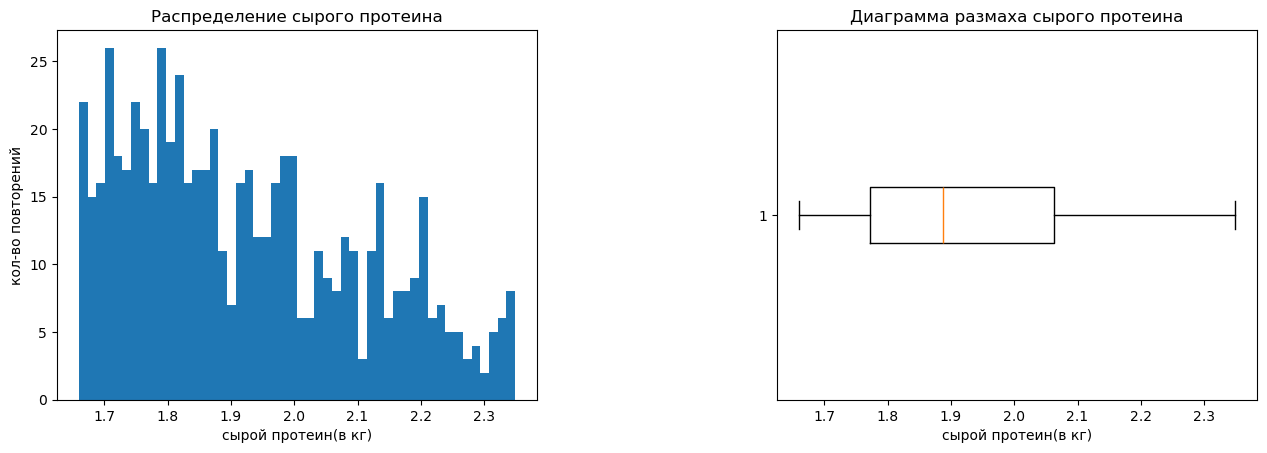

In [43]:
build_histogram_boxplot(ferma_main['сырой_протеин'], 'Распределение сырого протеина', 'Диаграмма размаха сырого протеина', 'сырой протеин(в кг)', 50)

Показатель сырого протеина в основном лежит в диапазоне 1.6 - 2.06 кг. Остальная часть в пределах 2.06 - 2.349 кг.

Аномальных значений и выбросов  не обнаружено.

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64


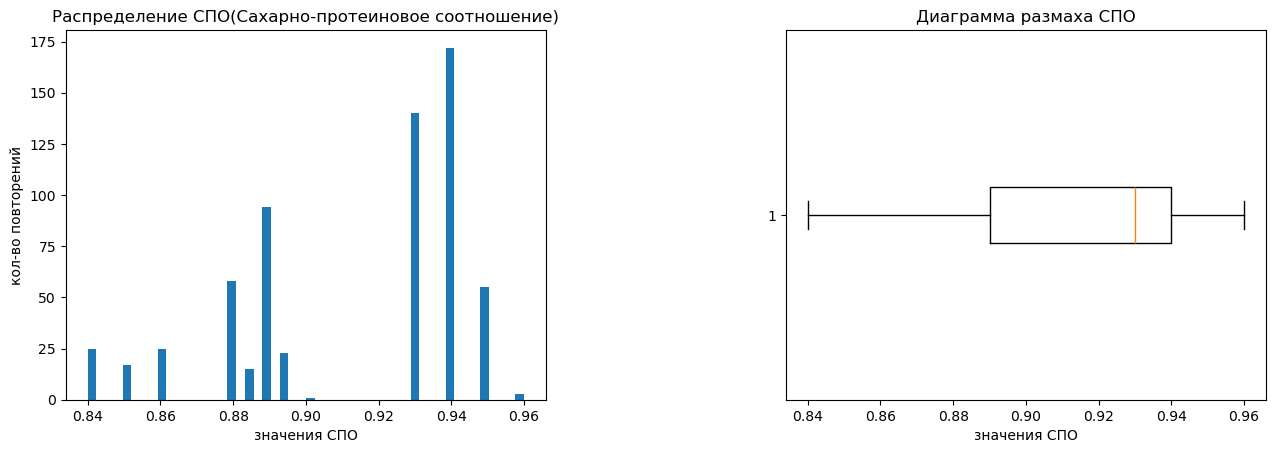

In [44]:
build_histogram_boxplot(ferma_main['спо'], 'Распределение СПО(Сахарно-протеиновое соотношение)', 'Диаграмма размаха СПО', 'значения СПО', 50)

Выделяются три 3 группы СПО:
1) 0.84 - 0.86
2) 0.88 - 0.90
3) 0.93 - 0.96

Для как каких-то коров нужно больше корма для каких-то меньше. 

Скорей всего такие группы получились из за влияния СПО на характеристики молока, то есть для каких-то коров нужно больше СПО, чтобы молоко было лучше.

Или данные группы образовались в зависимости от возраста коровы, или породы папы, имени...

Аномалий и выбросов не обнаружено.

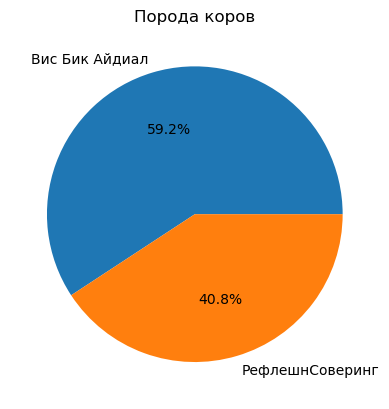

In [45]:
build_pie_chart(ferma_main['порода'], 'Порода коров')

Преобладает порода Вис Бик Айдиал на 18.4 % по сравнению с РефлешеСоверинг.

Аномалий не обнаружено.

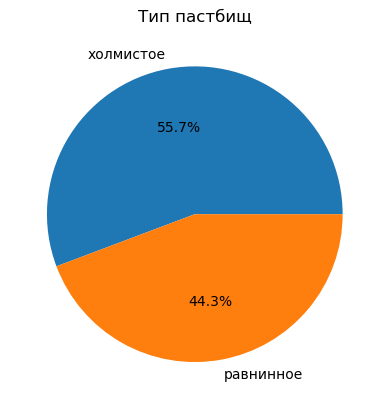

In [46]:
build_pie_chart(ferma_main['тип_пастбища'], 'Тип пастбищ')

В основном используется холмистое пастбище. 

Аномалий не обнаружено.

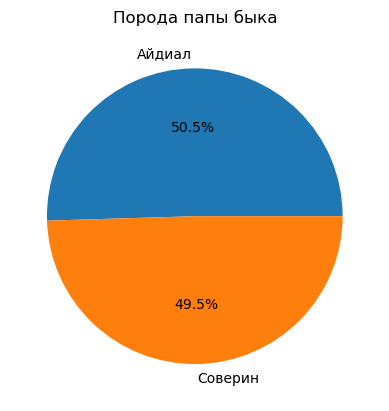

In [47]:
build_pie_chart(ferma_main['порода_папы_быка'], 'Порода папы быка')

Породы папы быка практически распределены поровну.

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность, dtype: float64


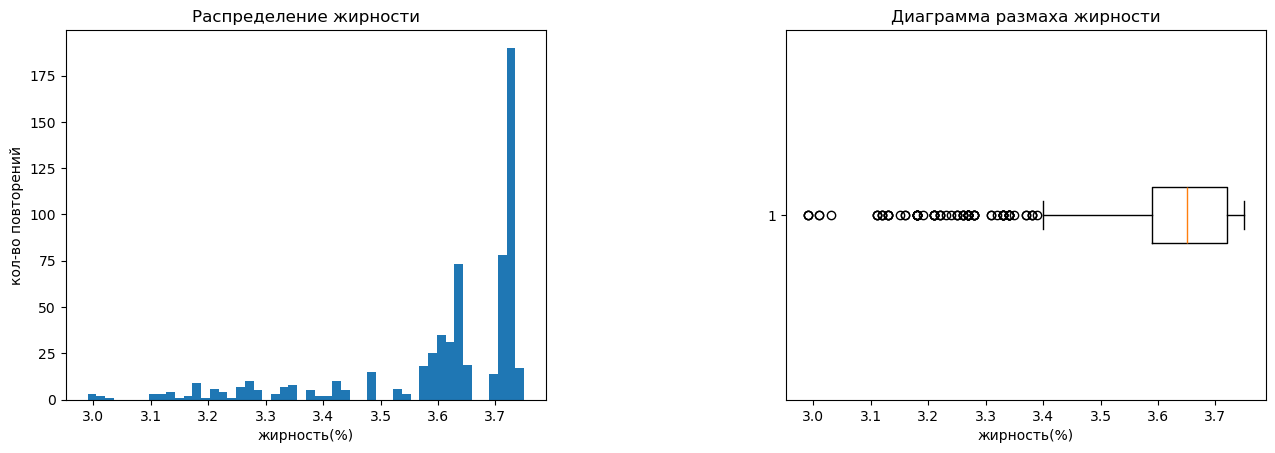

In [48]:
build_histogram_boxplot(ferma_main['жирность']*100, 'Распределение жирности', 'Диаграмма размаха жирности', 'жирность(%)', 50)

Много получилось выбросов. 

Нормальный диапазон примерно равен 3.4 - 3.75%. 

Из источника интернет:

Жирность молока у коровы может варьироваться в зависимости от породы, кормов, режима содержания и индивидуальных особенностей животного.  В среднем этот показатель составляет 3,2–5,5% и даже 6%. Отдельные коровы специализированных пород (например, джерсейской) могут давать молоко жирностью до 8%.

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок, dtype: float64


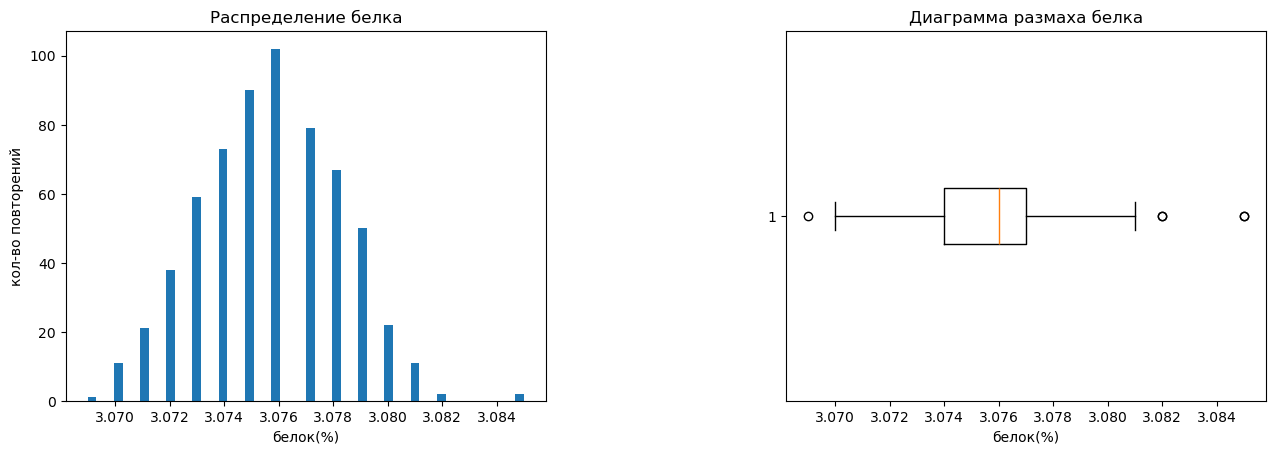

In [51]:
build_histogram_boxplot(ferma_main['белок']*100, 'Распределение белка', 'Диаграмма размаха белка', 'белок(%)', 50)

Нормальный диапазон значений примерно равен 3.072% - 3.081%.

Попадается немного выбросов. Значения достаточно редкие(единичные случаи), возможно какие то исключения из всех данных. Оставим как есть.

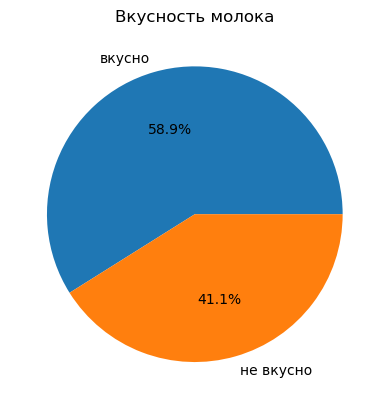

In [54]:
build_pie_chart(ferma_main['вкус_молока'], 'Вкусность молока')

Вкусное молоко преобладает, но не вкусное также занимает не малую долю из общего числа.

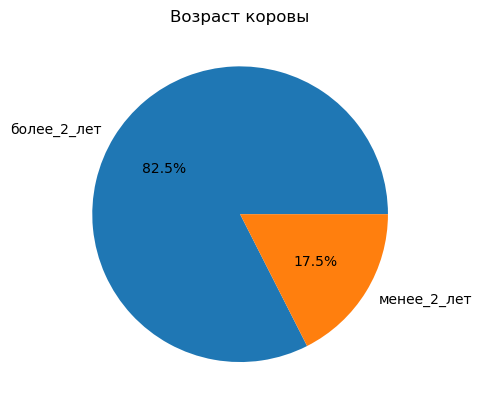

In [55]:
build_pie_chart(ferma_main['возраст'], 'Возраст коровы')

Большая часть коров имеют возраст больше 2 лет.

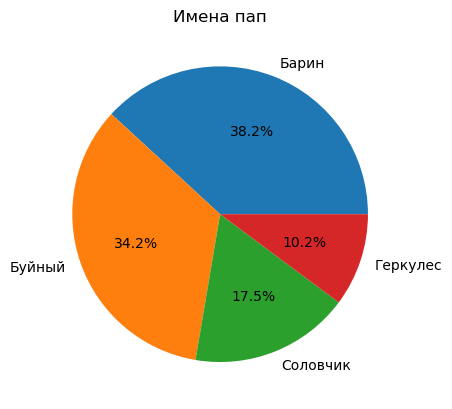

In [56]:
build_pie_chart(ferma_dad['имя_папы'], 'Имена пап')

Имена пап Барин и Буйный встречаются чаще остальных. Возможно это связано с тем, что они дают лучшее потомство, соответственно лучше молоко. Или данных коров дешеле обслуживать.

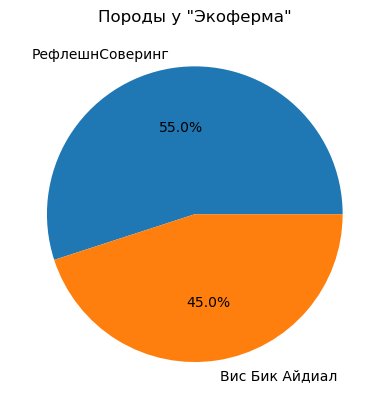

In [57]:
build_pie_chart(cow_buy['порода'], 'Породы у "Экоферма"')

У экофермы такие же породы коров. У фермера больше коров породы Вис Бик Айдиал, чем РефлешнСоверинг.

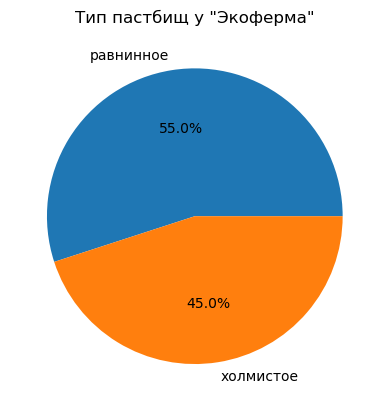

In [58]:
build_pie_chart(cow_buy['тип_пастбища'], 'Тип пастбищ у "Экоферма"')

У экофермы преобладает равнинное пастбище. У фермера больше используется холмистое пастбище.

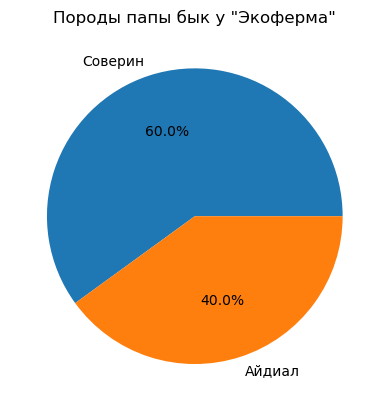

In [59]:
build_pie_chart(cow_buy['порода_папы_быка'], 'Породы папы бык у "Экоферма"')

У Экофермы больше породы папы быка Соверин. У фермера данных пород по ровну.

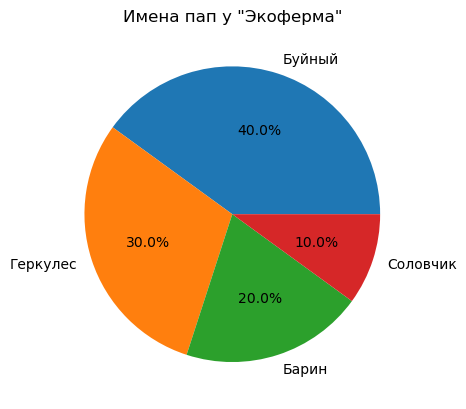

In [60]:
build_pie_chart(cow_buy['имя_папы'], 'Имена пап у "Экоферма"')

У экофермы в основом имя папы Буйный. У фермера Буйный и Барин.

count    20.000000
mean      3.577500
std       0.126818
min       3.340000
25%       3.510000
50%       3.590000
75%       3.650000
max       3.770000
Name: жирность, dtype: float64


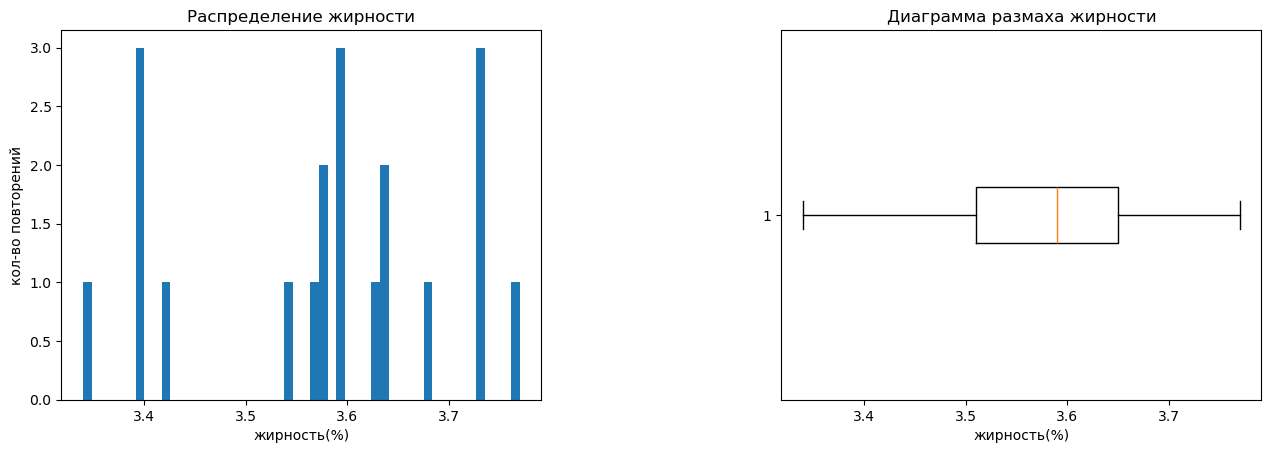

In [61]:
build_histogram_boxplot(cow_buy['жирность']*100, 'Распределение жирности', 'Диаграмма размаха жирности', 'жирность(%)', 50)

Выбросов не замечано. Каких то особых значений, аномалий нет. Жирность находится в нормальном диапазоне от 3.34 - 3.77 процентов.

count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: белок, dtype: float64


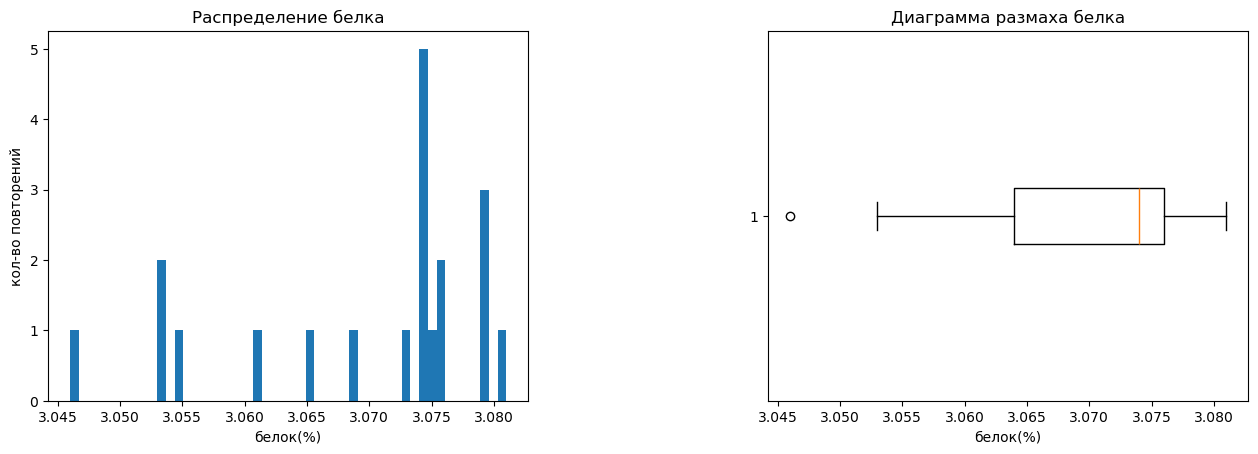

In [62]:
build_histogram_boxplot(cow_buy['белок']*100, 'Распределение белка', 'Диаграмма размаха белка', 'белок(%)', 50)

У фермера минимальное значение белка выше, чем у Экофермы, а максимальное совпадает. 

Можно удалить слишком маленькие значение белка(меньше 0,0307), но тогда потеряем много данных. 

У Экофермы чаще показатель белка ниже чем у Фермера, но так как Экоферма хочет увеличить характеристки корма на 5% то в будущем содержание белка может увеличиться, но на момент покупки коров останется все как есть, возможно, что у Фермера будет лучше корм, тогда содержание белка выравнется к более высоким значениям.

Оставим значения как есть.

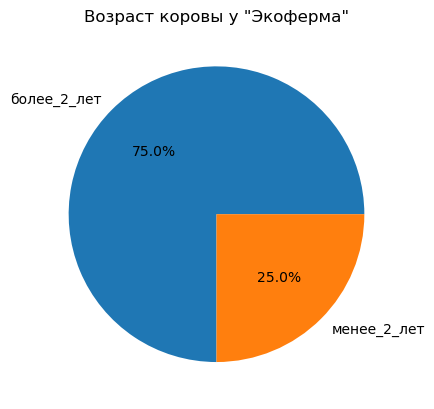

In [63]:
build_pie_chart(cow_buy['возраст'], 'Возраст коровы у "Экоферма"')

У Экофермы также в основном возраст коров более 2 лет.

Выводы:
1) Построили и описиали графики для всех признаков;
2) Удалили выброс у столбца `удой`;
3) Удалили выбросы у столбца `жирность`, оставили диапазон данных 3.2 - 3.75%.
4) Удалили выбросы у столбца `белок`, оставили диапозон 3.070 - 3.081%.
5) У категориальных переменных не было обнаружено проблем;

## Корреляционный анализ признаков в датасете `ferma_main.csv`

Задачи:
1) Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками.

2) Построим диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков.

3) Сделаем выводы о взаимосвязи признаков.

4) Определим какой тип взаимосвязи между целевым и входными признаками.

5) Определим есть ли нелинейные связи между целевым и входными признаками.

6) Определим есть ли мультиколлинеарность между входными признаками.

In [64]:
#C помощью метода phik_matrix() оценим коэффициенты корреляции для категориальных признаков для разных порода
ferma_main.query('порода == "РефлешнСоверинг"')[['удой', 'порода_папы_быка', 'вкус_молока', 'возраст']].phik_matrix()

interval columns not set, guessing: ['удой']


,удой,порода_папы_быка,вкус_молока,возраст
удой,1.000000,0.570083,0.326860,1.000000
порода_папы_быка,0.570083,1.000000,0.000000,0.327099
вкус_молока,0.326860,0.000000,1.000000,0.148098
возраст,1.000000,0.327099,0.148098,1.000000


Сильная связь `удой` и `возраста`, но это связано с тем, что большая часать коров имеет возраст более 2 лет.

Заметная связь `удой` и  `породы_папы_быка`, но опять же это связано с большим кол-вом определенной породы.

In [65]:
ferma_main.query('порода == "Вис Бик Айдиал"')[['удой', 'порода_папы_быка', 'вкус_молока', 'возраст']].phik_matrix()

interval columns not set, guessing: ['удой']


,удой,порода_папы_быка,вкус_молока,возраст
удой,1.000000,0.479980,0.189207,0.989556
порода_папы_быка,0.479980,1.000000,0.000000,0.368947
вкус_молока,0.189207,0.000000,1.000000,0.145412
возраст,0.989556,0.368947,0.145412,1.000000


Аналогично как и выше.

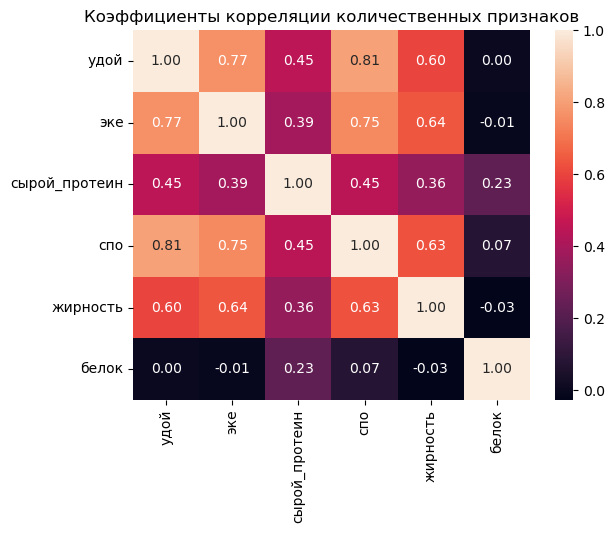

In [66]:
#Построим тепловую карту для отображения коэффициентов корреляци между признаками методом heatmap() из библиотеки seaborn()
sns.heatmap(ferma_main[['удой', 'эке', 'сырой_протеин', 'спо', 'жирность', 'белок']].corr(), annot=True, fmt='.2f') 
plt.title('Коэффициенты корреляции количественных признаков')
plt.show()

Наблюдается высокая связь целового признака `удой` с  `эке`,  `спо` и `жирность`.

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции между входными признаками от 0.9 до 0.95 по модулю. Здесь её нет.

In [67]:
#Создадим функции для определения коэффициента корреляции Пирсона и диаграммы рассеяния
def pearson_corr(column_1, column_2, title):
    # устанавливаем цвета для каждой породы
    colors = {'Вис Бик Айдиал': 'blue', 'РефлешнСоверинг': 'red'}

    plt.figure(figsize=(7,7))

    # строим диаграмму рассеяния
    for breed, color in colors.items():
        # фильтруем данные по породе
        filtered_data = ferma_main[ferma_main['порода'] == breed]

        # строим диаграмму рассеяния для этих данных
        plt.scatter(column_1, column_2, data=filtered_data, color=color)

        # подсчет корреляции Пирсона
        print(f'''Корреляция между {column_1} и {column_2} для {breed}:\
        {ferma_main.loc[ferma_main['порода'] == breed, column_1].corr(ferma_main[column_2]).round(2)}
        ''')
        
    plt.title(title)
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.legend(list(colors.keys()))
    plt.show()

In [68]:
#Создадим функции для определения коэффициента корреляции Спирмана и диаграммы рассеяния
def spearmanr_corr(column_1, column_2, title):
    # устанавливаем цвета для каждой породы
    colors = {'Вис Бик Айдиал': 'blue', 'РефлешнСоверинг': 'red'}

    plt.figure(figsize=(7,7))

    # строим диаграмму рассеяния
    for breed, color in colors.items():
        # фильтруем данные по породе
        filtered_data = ferma_main[ferma_main['порода'] == breed]
        # строим диаграмму рассеяния для этих данных
        plt.scatter(column_1, column_2, data=filtered_data, color=color)
        # подсчет корреляции Спирмена
        rho, p = spearmanr(
            ferma_main.loc[ferma_main['порода'] == breed, column_1],
            ferma_main.loc[ferma_main['порода'] == breed, column_2]
        )
        print(f'''Корреляция Спирмена между {column_1} и {column_2} для породы {breed}: {rho.round(2)}
        Значение p: {p}
        ''')
    plt.title(title)
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.legend(list(colors.keys()))
    plt.show()

Корреляция между удой и эке для Вис Бик Айдиал:        0.77
        
Корреляция между удой и эке для РефлешнСоверинг:        0.76
        


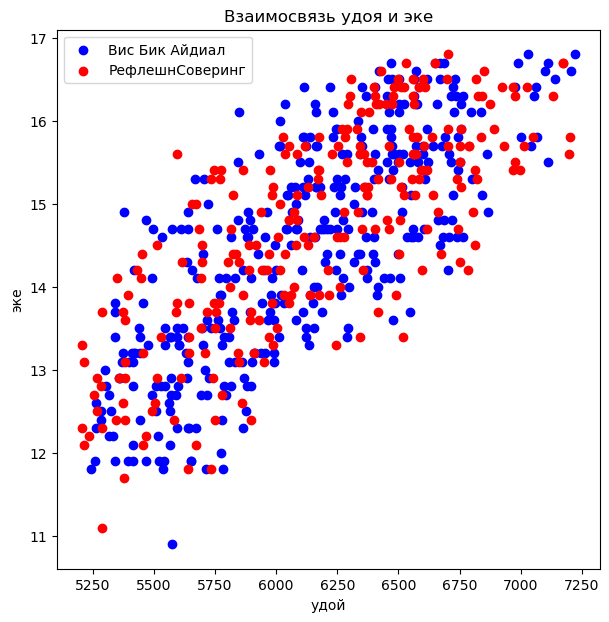

In [69]:
#Вызовим ряд функций для определения коэфф. корреляции и отображнеия диграмм рассеяния
#всех количественных признаков с учётом категориальных признаков породы коровы
pearson_corr('удой', 'эке', 'Взаимосвязь удоя и эке')

По шкале Чеддока между `удой` и `эке` высокая прямая взаимосвязь. 

Для породы Вис Бик Айдиал связь лучше, чем для РефлешнСоверинг, но отличие не сильное.

Корреляция между удой и сырой_протеин для Вис Бик Айдиал:        0.42
        
Корреляция между удой и сырой_протеин для РефлешнСоверинг:        0.48
        


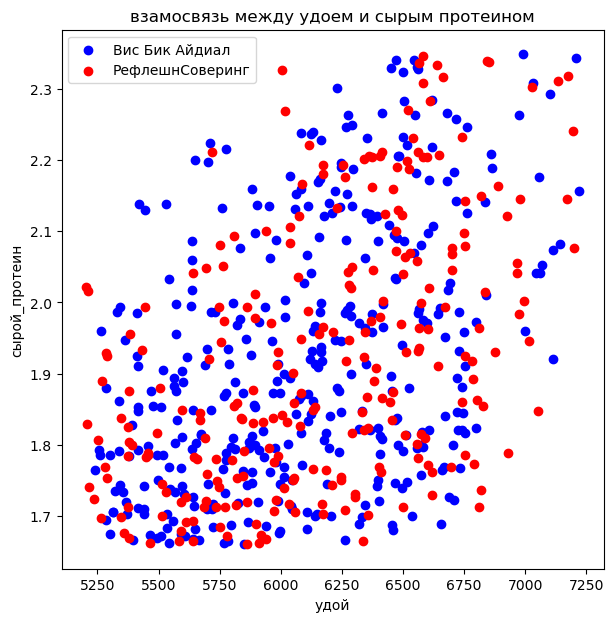

In [70]:
pearson_corr('удой', 'сырой_протеин', 'взамосвязь между удоем и сырым протеином')

По шкале Чеддока между `удой` и `сырым протеином` умеренная прямая взаимосвязь.

Для породы РефлешнСоверинг(0.47) взаимосвязь лучше, чем для Вис Бик Айдиал(0.4).

Корреляция Спирмена между удой и спо для породы Вис Бик Айдиал: 0.79
        Значение p: 1.8200547071843682e-81
        
Корреляция Спирмена между удой и спо для породы РефлешнСоверинг: 0.77
        Значение p: 2.043051132699784e-52
        


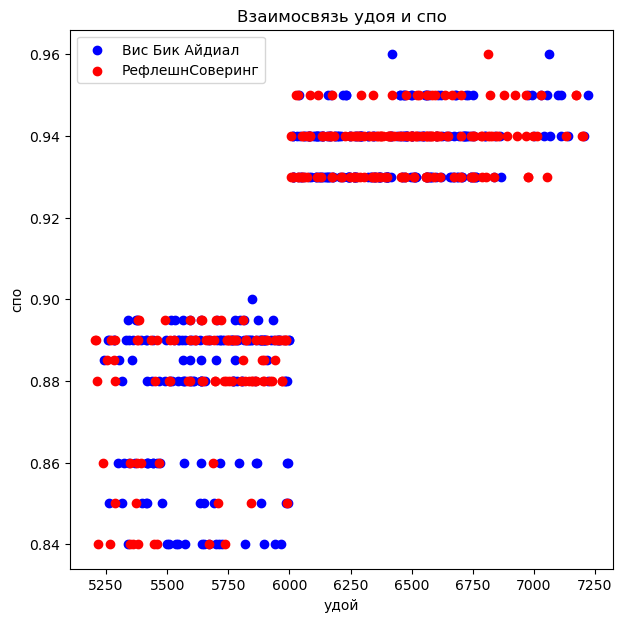

In [71]:
spearmanr_corr('удой', 'спо', 'Взаимосвязь удоя и спо')

Данные между `удоя` и `спо` распределена ненормально, поэтому используем коэфф. Спирмена. 

Между удоем и спо наблюадается сильная положительная связь(0.78 и 0.76).

Значение p-value очень маленькое, значит связь между переменными является статически значимой.

Можно выделить две группы:
1) 0.84 - 0,9 спо;
2) 0.93 - 0.96 спо.

Наблюдается связь: чем больше сахарно-протеиного отношения(спо), тем больше удоя.

Корреляция Спирмена между удой и жирность для породы Вис Бик Айдиал: 0.71
        Значение p: 1.0175606689737748e-58
        
Корреляция Спирмена между удой и жирность для породы РефлешнСоверинг: 0.64
        Значение p: 2.0357435146794884e-31
        


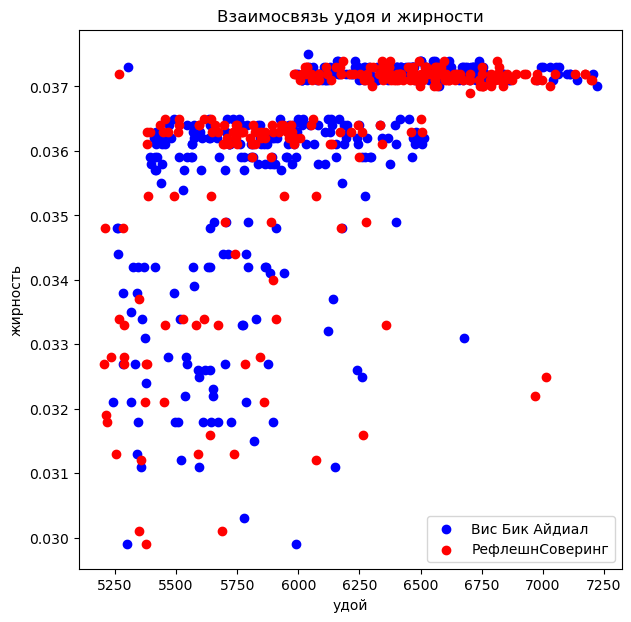

In [72]:
spearmanr_corr('удой', 'жирность', 'Взаимосвязь удоя и жирности')

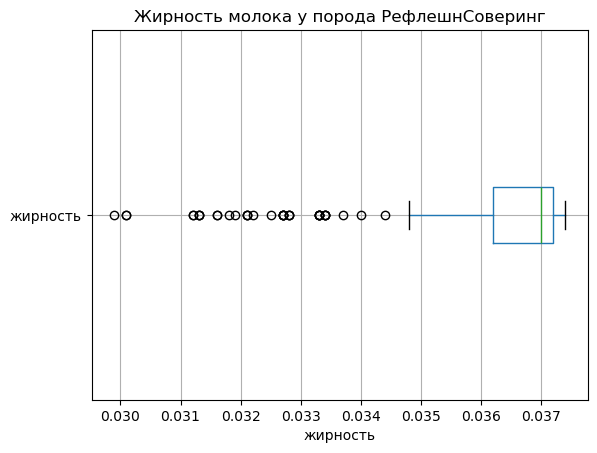

In [73]:
#Посмотрим у какой породы молоко большей жирности
ferma_main.query('порода == "РефлешнСоверинг"')[['жирность']].boxplot(vert = False)
plt.title('Жирность молока у порода РефлешнСоверинг')
plt.xlabel('жирность')
plt.show()

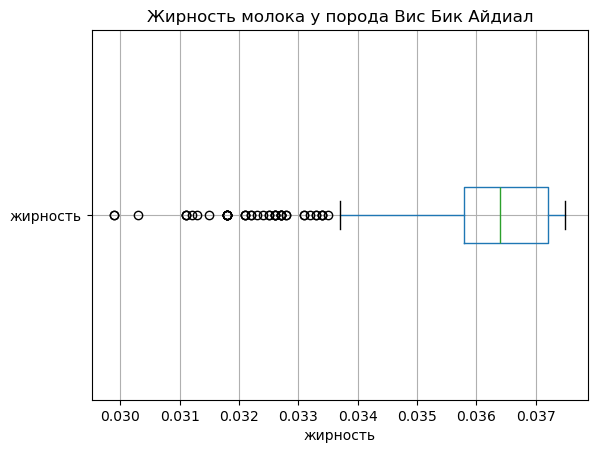

In [74]:
ferma_main.query('порода == "Вис Бик Айдиал"')[['жирность']].boxplot(vert = False)
plt.title('Жирность молока у порода Вис Бик Айдиал')
plt.xlabel('жирность')
plt.show()

Данные между `удоя` и `жирность` распределена ненормально, поэтому используем коэфф. Спирмена. 

Между удоем и жирностью наблюдается сильная положительная связь(0.7и 0.61),у породы Вис Бик Айдиал жирность больше влияет на удой, чем у РефлешнСоверинг.

У породы РефлешнСоверинг молоко имеет больше жирность.

Значение p-value очень маленькое, значит связь между переменными является статически значимой.

Здесь также можно выделить группы:
1) Примерно в диапозоне 6000 - 7250 кг, жирность около 3.7%.
2) Диапазон 5300 - 6500 кг, жирность около 3.6%.
3) Диапазон 5250 -7000 кг, жирность распространена хаотично 3.2 - 3.6%.

В целом чем больше жирность, тем удой может быть больше, но попадаются противоположные моменты.

75% молока имеет жирность больше 3.6%.

Получается, если удой должен быть не меньше 6000 кг в год, то лучше чтобы, жирность была не меньше 3.6%.

Корреляция Спирмена между удой и белок для породы Вис Бик Айдиал: 0.02
        Значение p: 0.6410678375662311
        
Корреляция Спирмена между удой и белок для породы РефлешнСоверинг: 0.01
        Значение p: 0.8887341394242578
        


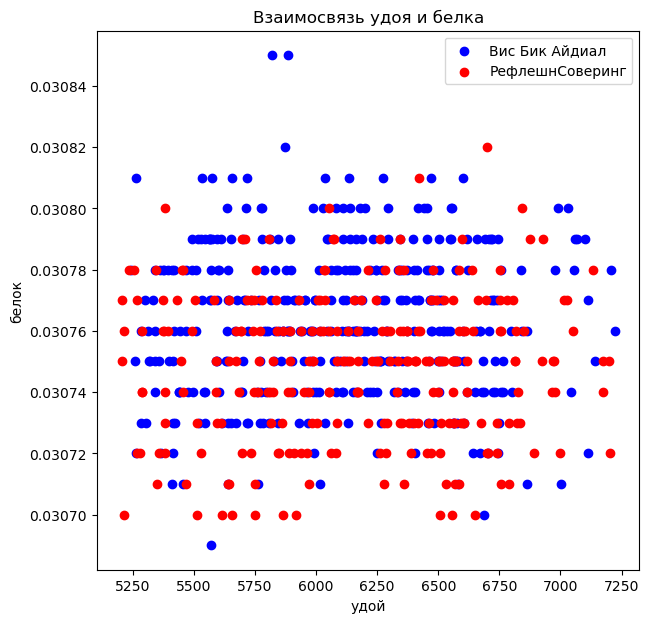

In [75]:
spearmanr_corr('удой', 'белок', 'Взаимосвязь удоя и белка')

Данные между `удоя` и `белка` распределена ненормально, поэтому используем коэфф. Спирмена.

Между удоем и белком наблюдается очень слабая связь(0.02 и 0.01).

Значение p-value 93% , значит связь между переменными является статически не значимой.

У породы Вис Бик Айдиал чаще попадается повышенное содержание белка.

Содержание белка не влияет на кол-во удоя.

Вывод:
- Сильная положительная линейная связь целевого признака `удой` c `эке`;
- Умеренная прямая связь целевого признака `удой` с `сырой_протеин`, но линейности не наблюдается;
- При взаимосвязи целевого признака `удой` с `спо` выделятся две группы: в одной меньше удоя и меньше спо, в другой больше удоя и больше спо;
- Связь `удой` с `спо` нелинейная;
- При взаимосвязи целевого признака `удой` с `жирность` выделятся 3 группы: в одной удой 6000 - 7250, жирность около 0.037, в другой удой 5300 - 6500 жирность около 0,036 и в последней все распределено хаотично в диапазоне: удой 5250 - 7000 кг, жирность 0.032-0.037;
- Связь нелинейна `удой` с `жирность`,;
- При взаимосвязи целевого признака `удой` с `спо` и с `жирность`, в целом можно сказать, что чем больше `спо` и  `жирность`, тем больше будет удоя.
- Взаимосвзь `удой` с `белок` не наблюдается;
- Мультиколлиниарность не наблюдается.

## Задача регрессии 

### Первая модель

План:

1) Построим модель линейной регрессии на данных датасета farm_main.csv.
2) Используем в качестве целевого признак `Удой`.
3) Из всего набора факторов выберем признаки, которые подходят для нашей модели.
4) Разобьём данные на обучающую и тестовую выборки.
5) Нормализуйте категориальные признаки с помощью One-Hot Encoding.
6) Масштабируйте количественные признаки с помощью StandardScaler.
7) Создадим модель линейной регрессии и получим прогноз.
8) Оценим качество модели на тестовой выборке: рассчитаем R², проанализируем остатки с помощью графиков.
9) Оформим выводы. Укажим: 
- Уровень R² модели;
- Какие выводы следуют из анализа остатков;
- Какие нужны дополнительные исследования.


In [76]:
#Создадим функции для построения модели линейной регрессии
try:
    def model(df, y, cat_col_names, num_col_names):
    
        X = df.drop(y, axis=1)
        y = df[y]
    
        RANDOM_STATE = 42
        
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            random_state=RANDOM_STATE
        )
    
        # подготовка признаков (масштабирование и кодирование)
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
        X_test_ohe = encoder.transform(X_test[cat_col_names])
    
        encoder_col_names = encoder.get_feature_names_out()
    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train[num_col_names])
        X_test_scaled = scaler.transform(X_test[num_col_names])
    
        X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
        X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
        X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
        X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
        # обучение модели и получение предсказаний на тестовых данных
        model_lr  = LinearRegression()
        model_lr.fit(X_train, y_train)
    
        predictions = model_lr.predict(X_test)
    
        return [X_train, X_test, y_train, y_test, predictions, encoder, scaler, model_lr]
except:
    print('что-то пошло не так')

In [77]:
#Создаим функцию метрики: коэффициент детерминации R2
def R2(df, y, cat_col_names, num_col_names):
    model_m = model(df, y, cat_col_names, num_col_names)
    r2 = r2_score(model_m[3], model_m[4])
    return round(r2, 2)

In [78]:
#Создаим функцию метрик: среднеквадратичная ошибка MSE
def MSE(df, y, cat_col_names, num_col_names):
    model_m = model(df, y, cat_col_names, num_col_names)
    mse = mean_squared_error(model_m[3], model_m[4])

    return round(mse, 2)

In [79]:
#Создаим функцию метрики: средняя абсолютная ошибка MAE
def MAE(df, y, cat_col_names, num_col_names):
    model_m = model(df, y, cat_col_names, num_col_names)
    mae = mean_absolute_error(model_m[3], model_m[4])

    return round(mae, 2)

In [80]:
#Создаим функцию метрики: корень среднеквадратичной ошибк RSME
def RSME(df, y, cat_col_names, num_col_names):
    model_m = model(df, y, cat_col_names, num_col_names)
    rsme = mean_squared_error(model_m[3], model_m[4])**0.5

    return round(rsme, 2)

In [81]:
#Создадим функцию для анализа остатков 
def quality_model(df, y, cat_col_names, num_col_names):
    # анализ остатков
    model_m = model(df, y, cat_col_names, num_col_names)
    residuals = model_m[3] - model_m[4]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(model_m[4], residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

В качестве категориальных признаков выберем `порода`, `тип_пастбища`, `порода_папы_быка`, `возраст`.

Для количественных признаков выберем `эке`, `спо`, `сырой_протеин`, так они всех больше влияют на качество корма, соответсвенно и на удой.

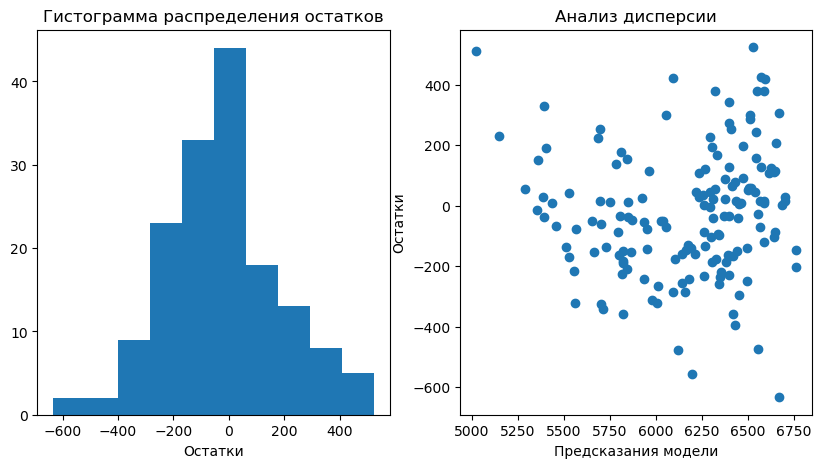

R2: 0.78
MSE: 43887.02
MAE: 164.24
RSME: 209.49


In [82]:
#Вызовим все необходимые функции для предсказания удоя, оценки качества модели и построение граффиков для анлиза остатков
df = ferma_main
y = 'удой'
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
num_col_names = ['эке', 'спо', 'сырой_протеин']

quality_model(df, y, cat_col_names, num_col_names)
print('R2:', R2(df, y, cat_col_names, num_col_names))
print('MSE:', MSE(df, y, cat_col_names, num_col_names))
print('MAE:', MAE(df, y, cat_col_names, num_col_names))
print('RSME:', RSME(df, y, cat_col_names, num_col_names))

Выводы:
1) Распределение получилось несимметричное со смещением влево.
2) Остатки на диаграмме показывают, что модель может работать неустойчиво, поскольку разброс остатков непостоянен.
3) Для улучшение модели нужно добавить новые признаки, либо трансформировать данные.
4) По метрике R2 в 82% случаев предсказание модели ближе к истине, чем среднее значение целевого признака.
5) По метрике MAE в среднем модель отклоняется от истинного значения целевого признака на 148.51 кг удой.
6) По метрике RSME В среднем модель ошибается примерно на 189 кг удоя.


### Вторая модель

In [83]:
#Преобразуем столбец 'спо' в категориальный признак путем добавления отдельного столбца 'спо_категория'
ferma_main['спо_категория'] = ferma_main['спо'].apply(lambda x: 'более_0.92' if x > 0.9 else 'менее_0.92')
#Добавим новый столбец 'эке_2' где значения 'эке' будут в квадрате
ferma_main['эке_2'] = ferma_main['эке']**2

In [84]:
#Посмотрим на новые столбцы
ferma_main.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,спо_категория,эке_2
0,1,5863,14.2,1.743,0.890,Вис Бик Айдиал,равнинное,Айдиал,0.0358,0.03076,вкусно,более_2_лет,менее_0.92,201.64
1,2,5529,12.8,2.138,0.890,Вис Бик Айдиал,равнинное,Соверин,0.0354,0.03079,вкусно,менее_2_лет,менее_0.92,163.84
2,3,5810,14.0,1.854,0.885,РефлешнСоверинг,холмистое,Соверин,0.0359,0.03074,не вкусно,более_2_лет,менее_0.92,196.00
3,4,5895,12.4,2.012,0.885,РефлешнСоверинг,холмистое,Айдиал,0.0340,0.03075,не вкусно,более_2_лет,менее_0.92,153.76
4,5,5302,12.8,1.675,0.885,Вис Бик Айдиал,равнинное,Соверин,0.0373,0.03073,вкусно,менее_2_лет,менее_0.92,163.84


Корреляция между удой и эке_2 для Вис Бик Айдиал:        0.77
        
Корреляция между удой и эке_2 для РефлешнСоверинг:        0.76
        


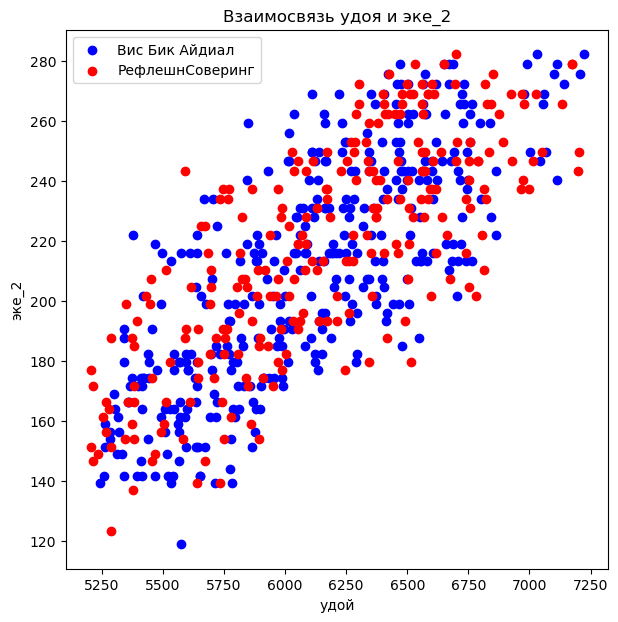

In [85]:
#Посмотрим как изменилась диграмма корреляции и коэффициент корреляци после возведения 'эке' в квадрат
pearson_corr('удой', 'эке_2', 'Взаимосвязь удоя и эке_2')

После возведения в квадрат график и коэффициенты корреляции остались без изменений.

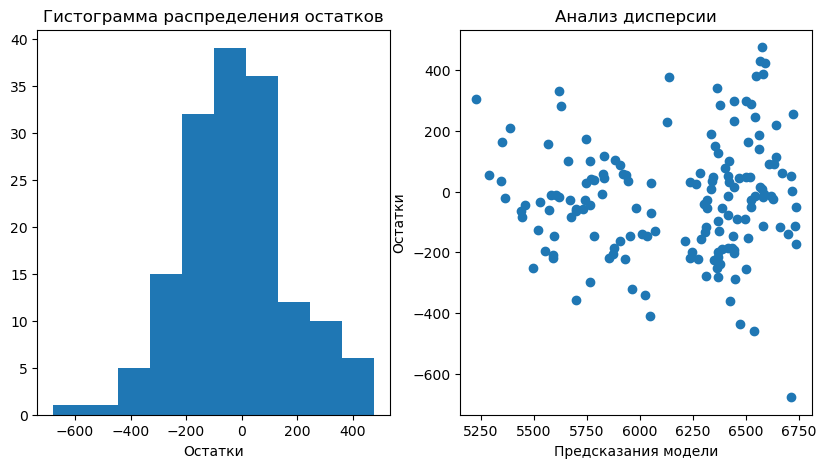

R2: 0.82
MSE: 37030.91
MAE: 149.04
RSME: 192.43


In [86]:
#Вызовим все необходимые функции для предсказания удоя, оценки качества модели и построение граффиков для анлиза остатков
df = ferma_main
y = 'удой'
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_категория']
num_col_names = ['эке_2', 'сырой_протеин']

quality_model(df, y, cat_col_names, num_col_names)
print('R2:', R2(df, y, cat_col_names, num_col_names))
print('MSE:', MSE(df, y, cat_col_names, num_col_names))
print('MAE:', MAE(df, y, cat_col_names, num_col_names))
print('RSME:', RSME(df, y, cat_col_names, num_col_names))

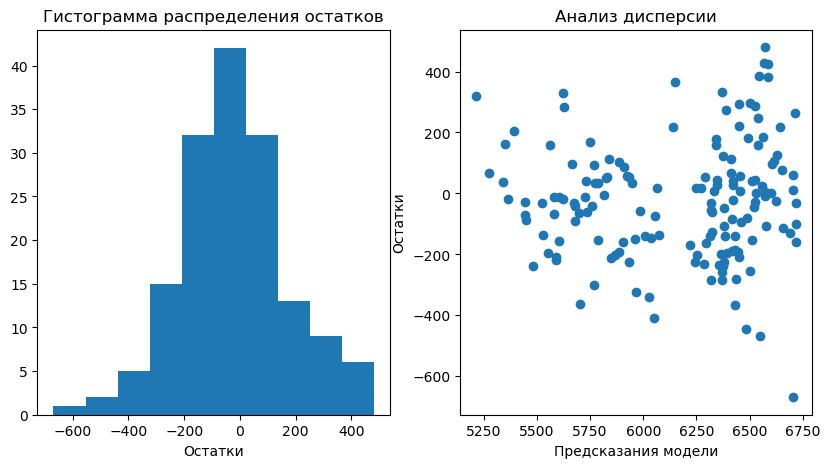

R2: 0.82
MSE: 37235.06
MAE: 149.06
RSME: 192.96


In [87]:
#Для интереса сравним как поведет себя модель, если оставим 'эке' как было
df = ferma_main
y = 'удой'
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_категория']
num_col_names = ['эке', 'сырой_протеин']

quality_model(df, y, cat_col_names, num_col_names)
print('R2:', R2(df, y, cat_col_names, num_col_names))
print('MSE:', MSE(df, y, cat_col_names, num_col_names))
print('MAE:', MAE(df, y, cat_col_names, num_col_names))
print('RSME:', RSME(df, y, cat_col_names, num_col_names))

Выводы:
1) Модель с парамером `эке_2` делает лучше предсказания.
2) Распределение получилось несимметричное со смещением влево.
3) Остатки на диаграмме показывают, что модель может работать неустойчиво, поскольку разброс остатков непостоянен.
4) Для улучшение модели нужно добавить новые признаки, либо трансформировать данные.
5) По метрике R2 в 83% случаев предсказание модели ближе к истине, чем среднее значение целевого признака.
6) По метрике MAE в среднем модель отклоняется от истинного значения целевого признака на 139.29 кг удой.
7) По метрике RSME В среднем модель ошибается примерно на 182.24 кг удоя.



### Третья модель

In [88]:
#Добавим в таблицу ferma_main данные имен пап из таблицы ferma_dad по общему столбцу 'id'
ferma_full = ferma_main.merge(ferma_dad, on='id')

In [89]:
#Проверим добавление
ferma_full.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,спо_категория,эке_2,имя_папы
0,1,5863,14.2,1.743,0.890,Вис Бик Айдиал,равнинное,Айдиал,0.0358,0.03076,вкусно,более_2_лет,менее_0.92,201.64,Буйный
1,2,5529,12.8,2.138,0.890,Вис Бик Айдиал,равнинное,Соверин,0.0354,0.03079,вкусно,менее_2_лет,менее_0.92,163.84,Соловчик
2,3,5810,14.0,1.854,0.885,РефлешнСоверинг,холмистое,Соверин,0.0359,0.03074,не вкусно,более_2_лет,менее_0.92,196.00,Барин
3,4,5895,12.4,2.012,0.885,РефлешнСоверинг,холмистое,Айдиал,0.0340,0.03075,не вкусно,более_2_лет,менее_0.92,153.76,Буйный
4,5,5302,12.8,1.675,0.885,Вис Бик Айдиал,равнинное,Соверин,0.0373,0.03073,вкусно,менее_2_лет,менее_0.92,163.84,Барин


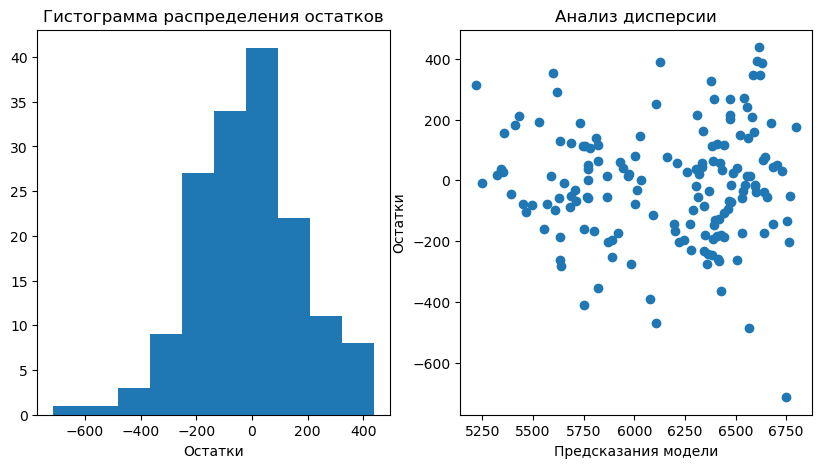

R2: 0.82
MSE: 35673.89
MAE: 146.16
RSME: 188.88


In [90]:
#
df = ferma_full
y = 'удой'
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'спо_категория', 'имя_папы']
num_col_names = ['эке_2', 'сырой_протеин']

quality_model(df, y, cat_col_names, num_col_names)
print('R2:', R2(df, y, cat_col_names, num_col_names))
print('MSE:', MSE(df, y, cat_col_names, num_col_names))
print('MAE:', MAE(df, y, cat_col_names, num_col_names))
print('RSME:', RSME(df, y, cat_col_names, num_col_names))

In [91]:
#Определим доверительный интервал с мощощью расчета квантилей методом quantile()
model_m = model(df, y, cat_col_names, num_col_names)
print('Доверительный интервал 3 модели')
print(np.quantile(model_m[4], 0.025))
print(np.quantile(model_m[4], 0.975))
print('Доверительный интервал тестовых данных')
print(np.quantile(model_m[3], 0.025))
print(np.quantile(model_m[3], 0.975))

Доверительный интервал 3 модели
5351.318280574306
6749.077628641809
Доверительный интервал тестовых данных
5356.8
6968.0


Выводы:
1) 3 Модель в совокупности со всеми добавлениями и изменениями дала чуть лучше показатели, по сравнению с 2 моделью.
2) Распределение немного изменилось, смещение осталось с левой стороны.
3) Местами разброс остаков непостоянен, практически также как и на 2 модели.
5) По метрике R2 = 82% 3 и 2 модель совпали.
6) По метрике MAE 3 модель лучше 2, в среднем модель отклоняется от истинного значения целевого признака на 146.16 кг удой, 
7) По метрике RSME 3 модель также лучше, в среднем модель ошибается примерно на 189 кг удоя.
8) Модель с 95% вероятностью будет попадать в интервал 5356 - 6968 кг.

### Прогноз удоя

In [92]:
#Добавим в dataframe 'cow_buy' столцы 'эке', 'сырой_протеин', 'спо' 
#Значения столбцов возьмем из 'ferma_main' как средние по всем данным, увеличим их на 5%
for i in ['эке', 'сырой_протеин', 'спо']:
    cow_buy[i] = (ferma_main[i].mean() * 1.05).round(3)

In [93]:
#Преобразуем столбец 'спо' в категориальный признак путем добавления отдельного столбца 'спо_категория'
cow_buy['спо_категория'] = cow_buy['спо'].apply(lambda x: 'более_0.92' if x > 0.9 else 'менее_0.92')
#Добавим новый столбец 'эке_2' где значения 'эке' будут в квадрате
cow_buy['эке_2'] = cow_buy['эке']**2

In [94]:
#Проверим преобразования
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,спо_категория,эке_2
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0354,0.03081,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176
2,РефлешнСоверинг,равнинное,Соверин,Барин,0.0359,0.03074,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,0.0340,0.03061,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,0.0364,0.03074,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176


In [95]:
#подготовка признаков (масштабирование и кодирование) для новых тестовых данных `cow_buy`
#будем использвать функцию model_m() обученной 3 модели для прогноза удоя
X_cow_ohe = model_m[5].transform(cow_buy[cat_col_names])

encoder_col_names = model_m[5].get_feature_names_out()

X_cow_scaled = model_m[6].transform(cow_buy[num_col_names])

X_cow_ohe = pd.DataFrame(X_cow_ohe, columns=encoder_col_names)
X_cow_scaled = pd.DataFrame(X_cow_scaled, columns=num_col_names)

X_cow = pd.concat([X_cow_ohe, X_cow_scaled], axis=1)

#Предскажем удой на тестовых данных `cow_buy` с помощью ранее обученной модели
predictions = model_m[7].predict(X_cow).round()

#Добавим столбец 'удой' c предсказанными значениями
for i in range(len(cow_buy)):
    cow_buy.loc[i,'удой'] = predictions[i]

In [96]:
#Выберем коров с удоем не меньше 6000 кг.
cow_buy.query('удой > 5999')

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,спо_категория,эке_2,удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6610.0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0354,0.03081,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6379.0
2,РефлешнСоверинг,равнинное,Соверин,Барин,0.0359,0.03074,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6284.0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,0.0340,0.03061,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6593.0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,0.0364,0.03074,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6542.0
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,0.0363,0.03053,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6425.0
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6610.0
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0357,0.03079,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6571.0
8,РефлешнСоверинг,равнинное,Соверин,Барин,0.0359,0.03074,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6284.0
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,0.0340,0.03079,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6401.0


Вывод:

- в таблицу `cow_buy` добавили характеристики корма(`эке`, `сырой_протеин`, `спо`) на 5% больше среднего по таблице `ferma_main`.
- дополнили таблицу `cow_buy` признаками `спо_категория`, `эке_2` для модели.
- на основе добавленных признаков, использовали лучшую модель для предсказания `удоя`.
- при характеристиках корма, увеличенных на 5%, удой получился у всех коров "ЭкоФерма" не меньше 6000 кг.

## Задача классификации

Цель: построить модель для предсказания вкуса молока.

Задачи:
1) Подготовим данные датасета ferma_main.csv и обучим на них модель LogisticRegression.
2) Оценим качество модели на тестовой выборке: рассчитаем метрики accuracy, recall, precision.
3) Построим матрицу ошибок.
4) Объясним, какая ошибка критичнее всего при покупке коров: первого или второго рода.
5) Сведем критичную ошибку к нулю.
6) Подведем итоги.

### Модель логистической регрессии

In [97]:
#Для удобства изменим данные столбца 'вкус_молока' на 1: вкусно, 0: не вкусно
ferma_full['вкус_молока'] = ferma_full['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

In [99]:
#Оценим изменение
ferma_full.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,спо_категория,эке_2,имя_папы
0,1,5863,14.2,1.743,0.890,Вис Бик Айдиал,равнинное,Айдиал,0.0358,0.03076,1,более_2_лет,менее_0.92,201.64,Буйный
1,2,5529,12.8,2.138,0.890,Вис Бик Айдиал,равнинное,Соверин,0.0354,0.03079,1,менее_2_лет,менее_0.92,163.84,Соловчик
2,3,5810,14.0,1.854,0.885,РефлешнСоверинг,холмистое,Соверин,0.0359,0.03074,0,более_2_лет,менее_0.92,196.00,Барин
3,4,5895,12.4,2.012,0.885,РефлешнСоверинг,холмистое,Айдиал,0.0340,0.03075,0,более_2_лет,менее_0.92,153.76,Буйный
4,5,5302,12.8,1.675,0.885,Вис Бик Айдиал,равнинное,Соверин,0.0373,0.03073,1,менее_2_лет,менее_0.92,163.84,Барин


In [100]:
#Оценим как количественные признаки взаимосвязаны к категориальными признаками.
ferma_full.phik_matrix()

interval columns not set, guessing: ['id', 'удой', 'эке', 'сырой_протеин', 'спо', 'жирность', 'белок', 'вкус_молока', 'эке_2']


,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст,спо_категория,эке_2,имя_папы
id,1.000000,0.000000,0.000000,0.115822,0.382303,0.611843,0.037776,0.320977,0.519949,0.000000,0.039659,0.000000,0.000000,0.000000,0.000000
удой,0.000000,1.000000,0.720719,0.463224,0.661359,0.164744,0.279540,0.519915,0.707654,0.058970,0.173122,0.998101,0.999947,0.722116,0.433409
эке,0.000000,0.720719,1.000000,0.456484,0.591190,0.123086,0.106758,0.171355,0.715914,0.000000,0.272265,0.771596,0.900428,0.979902,0.069197
сырой_протеин,0.115822,0.463224,0.456484,1.000000,0.387188,0.090925,0.096474,0.000000,0.397380,0.202474,0.176480,0.351685,0.537071,0.451582,0.111229
спо,0.382303,0.661359,0.591190,0.387188,1.000000,0.062660,0.155349,0.425601,0.645581,0.073787,0.572702,0.744410,1.000000,0.584376,0.409142
порода,0.611843,0.164744,0.123086,0.090925,0.062660,1.000000,0.213218,0.089330,0.222825,0.361851,0.000000,0.057295,0.028933,0.074709,0.382644
тип_пастбища,0.037776,0.279540,0.106758,0.096474,0.155349,0.213218,1.000000,0.000000,0.000000,0.099908,0.269063,0.128455,0.143022,0.148222,0.233149
порода_папы_быка,0.320977,0.519915,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.134582,0.000000,0.355817,0.407797,0.152239,0.982909
жирность,0.519949,0.707654,0.715914,0.397380,0.645581,0.222825,0.000000,0.000000,1.000000,0.000000,0.198793,0.677913,0.922373,0.714925,0.090409
белок,0.000000,0.058970,0.000000,0.202474,0.073787,0.361851,0.099908,0.134582,0.000000,1.000000,0.143857,0.000000,0.000000,0.000000,0.091102


Наблюдается мультиколлинеарность у признаков: 
- `имя_папы` с `порода_папы_быка`; 
- `удой` c `возраст`, `спо_категория`;
- `эке` с `спо_категория`;

Для выбора признаков в модель будем это учитывать.

Новый категориальный признак `жирность_категория` слабо влияет на `вкус_молока`.

`вкус_молока` имеет умеренную прямую связь с признаком `спо`. С остальными признакми наблюдается слабая прямая связь.


In [101]:
#Сохраним в переменные категориальные и количественные переменные
cat_col_names = ['тип_пастбища', 'возраст', 'порода', 'порода_папы_быка', 'спо_категория', 'имя_папы']
num_col_names = ['эке_2', 'спо', 'сырой_протеин', 'белок', 'жирность']

#Сохраним входные признаки и целевой
X = ferma_full.drop('вкус_молока', axis=1)
y = ferma_full['вкус_молока']

# объявляем константы в соответствии с PEP-8
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
X,
y,
random_state=RANDOM_STATE
)

# приводим значения всех признаков к единой шкале

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)


X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#Обучим модель на основе логистической регрессии
clf = LogisticRegression(random_state=RANDOM_STATE)

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [102]:
for feature_number, feature_name in enumerate(X_train.columns):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.2f}")

тип_пастбища_холмистое: +1.88
возраст_менее_2_лет : +0.84
порода_РефлешнСоверинг: +0.97
порода_папы_быка_Соверин: +1.03
спо_категория_менее_0.92: +9.93
имя_папы_Буйный     : +0.98
имя_папы_Геркулес   : +0.96
имя_папы_Соловчик   : +0.67
эке_2               : +1.56
спо                 : +3.10
сырой_протеин       : +1.12
белок               : +1.23
жирность            : +0.86


Самое большое влияние оказывает холмистое пастбища,там больше всех получается вкусное молоко. Остальные признаки практически оказывают одинаковое влияние.

Между `вкус_молока` и `порода_РефлешнСоверинг`, `жирность`, `возраст_менее_2_лет` наблюадается отрицательная корреляция. Но при удалении данных признаков качестов модели снижается.




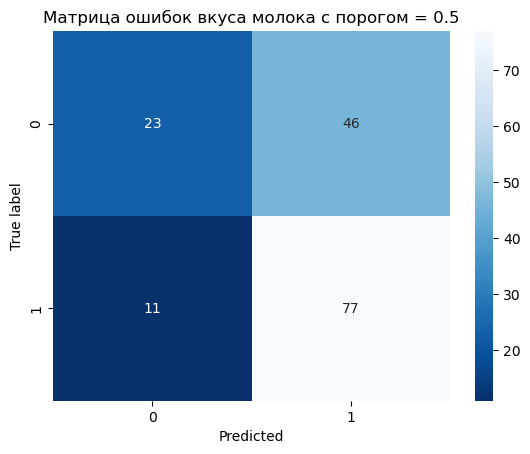

In [103]:
#Построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок вкуса молока c порогом = 0.5')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

In [104]:
#Рассчитаем метрики для оценки качества модели
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('accuracy:', round(acc, 3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

accuracy: 0.637
recall:  0.875
precision:  0.626


Из всего набора данных модель дала 68.4% верных ответов. Это явно плохой результат, есть риски получить невкусное молоко.

Модель ошибается 19 раз, предсказывая, что молоко невкусное, но фактически оно вкусное. Это параметр FalseNegative. По метрике recall полнота составляет 80%.

Модель ошибается 30 раз, предсказывая, что молоко вкусное, но фактически оно не вкусное. Это параметр FalsePositive. По метрике precision точность составляет 72%.

Здесь явно нужно уменьшить метрику recall и увеличить до 1 метрику precision. Так как пусть модель лучше предскажет невкусное молоко и, но оно окажется вкусным, чем предскажет, что молоко вкусное,а фактически будет невкусное.



In [105]:
#Создадим новый dataframe, где сохраним истинные значения целового признака и оценки вероятностей для класса
y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test.reset_index(drop = True), y_proba),
             columns = ['y_valid', 'y_proba'])

display(data.head())

,y_valid,y_proba
0,1,0.662577
1,1,0.688301
2,1,0.466735
3,0,0.436427
4,1,0.821106


In [106]:
#С помощью функции linspace создадим список порогов от 0.1 до 1
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 1000,endpoint=False)]

In [107]:
#Наглядно оценим  таблцу с порогами
for i in thresholds:
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x>= i else 0)
data.head()

,y_valid,y_proba,y_pred_0.1,y_pred_0.11,y_pred_0.12,y_pred_0.13,y_pred_0.14,y_pred_0.15,y_pred_0.16,y_pred_0.17,...,y_pred_0.91,y_pred_0.92,y_pred_0.93,y_pred_0.94,y_pred_0.95,y_pred_0.96,y_pred_0.97,y_pred_0.98,y_pred_0.99,y_pred_1.0
0,1,0.662577,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0.688301,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0.466735,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0.436427,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0.821106,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [108]:
# создаём переменные, кототрые будуд хранить список значения порогов, метрик
threshold_values = []
precision_values = []
recall_values = []
false_negative = []
false_positiv = []

#с помощью цикла найдем порог, при котором precision = 1
#сохраним в переменные список значений порог, метрик и значений матрицы ошибок
for i in thresholds:
    threshold_values.append(i)
    pre = precision_score(data['y_valid'], data['y_pred_'+str(i)])
    rec = recall_score(data['y_valid'], data['y_pred_'+str(i)])
    recall_values.append(rec)
    precision_values.append(pre)
    cm = confusion_matrix(data['y_valid'], data['y_pred_'+str(i)])
    false_negative.append(cm[1][0])
    false_positiv.append(cm[0][1])
    if pre == 1:
        limit = i
        print(f'Порог = {limit}')
        print(f'Precision = {pre}')
        break

Порог = 0.79
Precision = 1.0


In [109]:
#Создаим таблицу, где сохраним значения метрик, порогом и значения матрицы ошибок
threshold_table = pd.DataFrame(zip(threshold_values, precision_values, recall_values, false_negative, false_positiv), columns = ['threshold','precision', 'recall', 'false_neg', 'false_pos'])

In [110]:
threshold_table.query('precision > 0.88')

,threshold,precision,recall,false_neg,false_pos
728,0.76,0.903226,0.318182,60,3
729,0.76,0.903226,0.318182,60,3
730,0.76,0.903226,0.318182,60,3
731,0.76,0.903226,0.318182,60,3
732,0.76,0.903226,0.318182,60,3
733,0.76,0.903226,0.318182,60,3
734,0.76,0.903226,0.318182,60,3
735,0.76,0.903226,0.318182,60,3
736,0.76,0.903226,0.318182,60,3
737,0.76,0.903226,0.318182,60,3


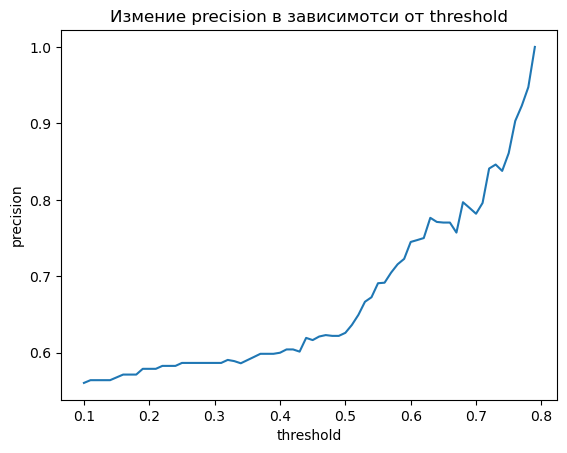

In [111]:
#Создадим график, где наглядно оценим измение метрки precision в зависимотси от разных порогов
plt.plot(threshold_table['threshold'], threshold_table['precision'])
plt.title('Измение precision в зависимотси от threshold')
plt.xlabel('threshold')
plt.ylabel('precision')
plt.show()

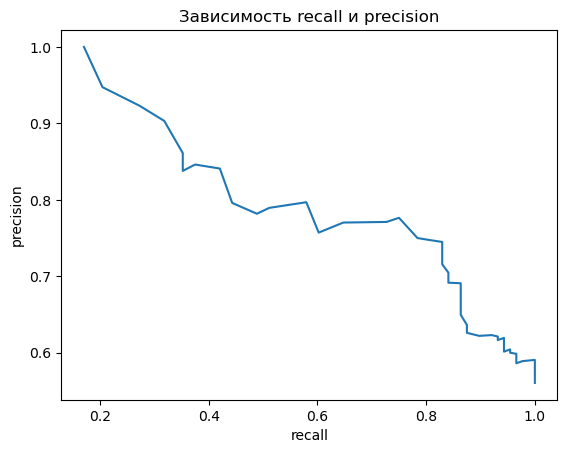

In [112]:
#Создадим график, где наглядно оценим взаимное измение метрик precision и recall
plt.plot(threshold_table['recall'], threshold_table['precision'])
plt.title('Зависимость recall и precision')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

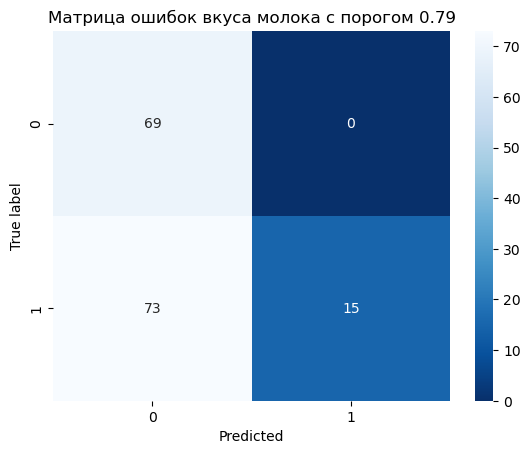

acc = 0.535031847133758
precision = 1.0
recall = 0.17045454545454544


In [113]:
#Построим матрицу ошибок с учетом нового порога
cm = confusion_matrix(data['y_valid'], data['y_pred_'+str(limit)])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title(f'Матрица ошибок вкуса молока с порогом {limit}')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

#Найдем значения метрик с учетом нового порога
acc = accuracy_score(y_test, data['y_pred_'+str(limit)])
precision = precision_score(y_test, data['y_pred_'+str(limit)])
recall = recall_score(y_test, data['y_pred_'+str(limit)])

print(f'acc = {acc}')
print(f'precision = {precision}')
print(f'recall = {recall}')


В результате получили, что при пороге = 0.81, precision = 1, recal = 0.04.

Мы исключили случаи когда модель может дать предсказание, что молоко вкусное, но фактически оно не вкусное, то есть уменьшили до min параметр FalsePositiv и метрику recall.

Если модель предсказывает, что молоко не вкусное, то она ошибается, и это молоко с большей вероятностью окажется вкусным.

### Прогноз вкуса молока

Определим вкус молока на основе готовой модели для данных таблицы `cow_buy`.

In [114]:
# приводим значения всех признаков к единой шкале
X_test_ohe = encoder.transform(cow_buy[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

X_test_scaled = scaler.transform(cow_buy[num_col_names])


X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)


X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

#на основе обученной модели предсказывает вкус молока
y_pred = clf.predict(X_test)

#сохраним значения оценкок вероятностей 
y_proba = clf.predict_proba(X_test)[:,1]


In [115]:
#Добавим столбец 'y_proba' с значениям оценкок вероятностей 
cow_buy['y_proba'] = clf.predict_proba(X_test)[:,1]

In [116]:
#посмотрим на добавление
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,спо_категория,эке_2,удой,y_proba
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6610.0,0.859495
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0354,0.03081,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6379.0,0.816986
2,РефлешнСоверинг,равнинное,Соверин,Барин,0.0359,0.03074,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6284.0,0.740552
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,0.0340,0.03061,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6593.0,0.677424
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,0.0364,0.03074,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6542.0,0.722635


In [117]:
#Добавляем столбец 'вкус_молока' с предсказанными значениями
#Используем порог 0.79
cow_buy['вкус_молока'] = cow_buy['y_proba'].apply(lambda x: 1 if x >= limit else 0 )

In [118]:
#Удалем не нужный столбец
cow_buy = cow_buy.drop('y_proba', axis = 1)

In [119]:
#Определяем коров "ЭкоФерма" с удоем не меньше 6000кг и вкусным молоком
cow_buy.query('(удой > 5999) and (вкус_молока == 1)')

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,спо_категория,эке_2,удой,вкус_молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6610.0,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0354,0.03081,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6379.0,1
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6610.0,1
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0357,0.03079,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6571.0,1
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,0.0340,0.03079,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6401.0,1
13,Вис Бик Айдиал,холмистое,Соверин,Барин,0.0342,0.03075,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6127.0,1
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,0.0373,0.03079,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6345.0,1


Выводы:

1) Изначально получили итоговую модель с порогом = 0.5 с параметрами метрик: acc = 0.684, precision = 0.8, recall = 0.17;
2) Подобрали порог = 0.79 для достижения  параметра precision = 1, в таком случае больше шанс получить вкусное молоко;
3) Получили итоговую модель с порогом = 0.79 с параметрами метрик: acc = 0.54, precision = 1, recall = 0.04;
4) Получили прогноз молока на итоговой модели, получилось 7 коров с вкусным молоком.

### Итог по моделям

In [120]:
#Подходящие коровы для фермера
cow_buy.query('(удой > 5999) and (вкус_молока == 1)')

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,эке,сырой_протеин,спо,спо_категория,эке_2,удой,вкус_молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6610.0,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0354,0.03081,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6379.0,1
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,0.0358,0.03076,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6610.0,1
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,0.0357,0.03079,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6571.0,1
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,0.0340,0.03079,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6401.0,1
13,Вис Бик Айдиал,холмистое,Соверин,Барин,0.0342,0.03075,менее_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6127.0,1
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,0.0373,0.03079,более_2_лет,15.276,2.02,0.959,более_0.92,233.356176,6345.0,1


В итоге для фермера получилось 7 коров "ЭкоФерма" с удоем не меньше 6000 кг. и с вкусным молоком. Фермер может купить коров с минимальным риском, в случае если характеристики корма(`спо`, `эке`, `сырой_протеин`) будут такими же как мы выбрали в обученной модели. Если  "ЭкоФерама" сделает характеристики молока хуже, то высока вероятность других исходов. В данном случае, так как у всех одинаковые характеристики корма нужно опираться на вспомогательные признаки. Для фермера лучше выбирать коров породы Вис Бик Айдиал с холмистого пастбища так как там больше попадается вкусное молоко.

Для улучшение качества модели линейной регрессии была сделана подготовка данных: предобработа, удаление выбросов, мастшабирование количественных и категориальных данных. Добавлено три признака `спо_категория`,	`эке_2`, `имя_папы`, после чего модель показала лучше результат как по анализу остатков так и по метрикам качества. 

Для улучшение качества модели логистической регрессии была сделана подготовка данных: предобработа, удаление выбросов, мастшабирование количественных и категориальных данных. Использование порога 0.81 для увеличения метрики precision и уменьшения recall помогло модели лучше предскавать те случаи,которые были выгодны для фермера.

Улучшить результаты регрессионных моделей можно, благодаря:
 - добавлению новых входных признаков(н-р, характеристики коровы: вес, болезни...).
 - исключение мультиколлинеарности меджу входными признаками.
 - изменение входных признаков(возведение в квадрат...)
 - удаление лишних входных признаков, которые слабо влияют на целевой признак.
 - изменеие количественного признака на категориальный, если есть для этого основания.

Улучшить результаты регрессионных моделей не всегда возможно, так как может быть это не линеная модель,слишком много категориальных признаков,когда мультиклассовая классификация не работает, вообщем когда проблема не может быть решена с помощью регрессионной модели. В таких случаях нужно использовать другие модели для других задач

Модель классификации, в том числе логистическая регрессиия имеют ряд метрик качества, которые важны для анализа рисков и экономисеских расчётов. Метрика `accuracy` позволяет оценить сколько правильных ответов выдает модель, но она мало несет информации и не всегда объясняет насколько модель применима к задаче. 

Для более точечной оценки логистической регрессии стоит изучить, какой вклад в оценку вероятности принадлежности к классу вносит каждый признак с помощью способа `отношение шансов`.

Метрика `precision` показывает точность, с которой модель присваивает объектам класс 1, то есть получает результат типа Positive. Иными словами, precision определяет, не слишком ли часто модель выставляет класс 1 объектам класса 0. Чем выше эта метрика, тем меньше таких случаев. В задаче кредитного агентства «Стонкс» precision покажет, всегда ли модель верно предсказывает дефолт клиента.


Метрика `recall`(полнота) измеряет, смогла ли модель классификации присвоить класс 1 всем объектам этого класса. Предсказания False Negative рассматриваются метрикой как «неучтённые» True Positive. Чем выше recall, тем больше прогнозов Positive модель смогла дать верно. В случае агентства «Стонкс» эта метрика подскажет, все ли дефолты удалось предугадать.

## Вывод

1) Выполнили предобработку данных:
    - пропусков не обнаружено;
    - удалили 5 явных дубликтов и 2 неявных в `ferma_main`;
    - Изменили единицы измерения: граммы в кг., процента в доли ед.
    - Типы данных в порядке


2) Провели исследовательский анализ:

    - построили графики и диграммы размаха для всех данных;
    - удалили выброс(45616 кг) в столбце `удой`;
    - 5250 - 7250 кг. - диапазон `удоя` у коров фермера;
    - 75% коров имеют удой больше 5750 кг.;
    - Выделяются три 3 группы `спо`: 0.84 - 0.86, 0.88 - 0.90, 0.93 - 0.96.
    - 75% молока имеет жирность больше 3.6%.
    - 75% молока имеет белок больше 3.074%.
    - 83% коров имеют возраст больше 2 лет;
    - 72.4% короров имеют имена пап Буйный или Барин;
    - Коровы у "ЭкоФермы" практически имеют похожие категориальные и количественные признаки.

3) Провели корреляционный анализ признаков в датасете `ferma_main.csv`:
 
    - сильная положительная линейная связь целевого признака `удой` c `эке`;
    - умеренная прямая связь целевого признака удой с сырой_протеин, но линейности не наблюдается;
    - при взаимосвязи целевого признака `удой` с `спо` выделяется две группы: меньше 0.91 и больше 0.91.
    - нелинейная связь с жирностью, но при жирности больше 3.6% наблюдается повышенный удой.
    - у породы РефлешнСоверинг молоко имеет больше жирность.
    - `белок` не влияет на `удой`.
    - у породы Вис Бик Айдиал чаще попадается повышенное содержание белка.
    - Мультиколлиниарность не наблюдается.
  
4) Построили несколько моделей линейной регрессии. Выбрали 3 модель как самую лучшую. Её краткое описание:
    - Добавили новые входные признаки: `спо_категория`,	`эке_2`, `имя_папы`.
    - Распределение получилось практически симметричным с небольшим смещением влево.
    - Местами разброс остаков непостоянен, но это лучше остальных моделей.
    - По метрике R2 в 82% случаев предсказание модели ближе к истине, чем среднее значение целевого признака.
    - По метрике MAE в среднем модель отклоняется от истинного значения целевого признака на 146 кг удой.
    - По метрике RSME в среднем модель ошибается примерно на 189 кг удоя.
    - Модель с 95% вероятностью будет попадать в интервал 5356 - 6968 кг.

В результате был сделан прогноз `удой` на данных из "Экофермы", с учётом того что в `cow_buy` были добалены средние характеристики корма(`спо`,	`эке`, `сырой_протеин`) из `ferma_main` увеличенные на 5%. `Удой` у коров из "Экофермы" получился у всех выше 6000 кг..

Так как на момент покупки характеристики корма и молока у "Экофермы" оствались ещё старыми, то фермеру лучше подождать когда компания даст информацию о фактических характеристиках корма и молока после увелечение `спо`,	`эке`, `сырой_протеин`.

5) Построили модель логистической регрессии. Выбрали порог 0.79, получили метрики:
    - acc = 0.54
    - precision = 1.0
    - recall = 0.17

С помощью данного порога(0.79), мы исключили варианты, когда модель предсказывает вкусное молоко, но  оно фактически оказывается не вкусное. 

В случае если модель предсказывает, что молоко не вскусное и ошибается,так как оно является фактически вкусным. Данный случай будет на пользу фермеру.
 
При использовании данной модели с порогом 0.79 получилось предсказать 7 коров "ЭкоФерма" с вкусным молоком и удоем больше 6000 кг..

В результате при выборе коров "ЭкоФерма" фермеру нужно учитывать, что характеристики корма(`спо`, `эке`, `сырой_протеин`) будут такими же как мы выбрали в обученной модели, в случае если они будут другими лучше ещё раз переобучить модель. 

Исходя из полученной модели у всех одинаковые характеристики корма, поэтому нужно опираться на вспомогательные признаки. Для фермера лучше выбирать коров породы Вис Бик Айдиал с холмистого пастбища, так как там больше попадается вкусное молоко и удой больше 6000 кг..